# Data Preprocessing
#### Run this script to proprocess all the data that will be coming in from one, many, or all of the following sources:
1. **MonkeyLogic:** (.bhv2 | .h5) behavior data *[500 or 1000Hz]*
  > * Photodiode data
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
2. **SpikeGLX:** (.meta & .bin) duplicates of analog data *[20000-30000Hz]*
  > * Photodiode data (split from ML)
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
3. **WhiteMatter:** (.mp4 | .avi) video files *[60-120 fps]*
***

## Find Files
`FileContainer` will hold the relevant files listed above. <br>
* Specify `ROOT_DIR` to set the directory when prompted to select the files.
* `WARNING` printed if dates and monkeys not aligned across files

In [1]:
%load_ext autoreload
%autoreload 2
import re
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
# Custom classes
from classes.FileContainer import FileContainer
from classes.SpikeGLX import SpikeGLX
# Custom functions
from spike_glx import read_SGLX

# pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

ROOT_DIR = '/Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/tasks'
file_container_obj = FileContainer(ROOT_DIR)

Select .bhv2/.h5 behavior file (i.e. 230927_Aragorn_choice.h5)
Behavior file selected: /Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/data/shared/Aragorn/20231106/231106_Aragorn_choice.h5
  MonkeyLogic Date: 231106
  MonkeyLogic Monkey: aragorn
Select directory containing White Matter video files (i.e. 230927_Aragorn)
Video files directory selected: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff/8. Probabilistic_Reward_Airpuff_Choice/videos/aragorn_231106/231106_Aragorn
  White Matter Video Date: 231106
  White Matter Video Monkey: aragorn
Select directory containing SpikeGLX files
SpikeGLX files directory selected: /Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/data/shared/Aragorn/20231106/aragorn_20231106/aragorn_20231106_g0
  SpikeGLX Date: 231106
  SpikeGLX Monkey: aragorn



***
## Convert MonkeyLogic File to Pandas
In order to run the behavior files through the preprocessing pipeline, we'll need to convert the MonkeyLogic file (either `.bhv2` or `.h5`) into a Session object which contains the following relevant attributes:
> * `session_obj.df`: pandas DataFrame with columns:
>   * `'photodiode'`: photodiode signal
>   * `'Gen2'`: WM sync signal
>   * `'Gen3'`: WM save signal
> * `'session_obj.video_path'`: directory of WM videos
> * `session_obj.monkey`: monkey name
> * `session_obj.date`: date of session (<YYMMDD>)

In [2]:
session_obj, error_dict, behavioral_code_dict = file_container_obj.ml_to_pd()

Parsing .h5 file...
Total number of trials: 589
  Choice task detected.
Parsing session data...


  0%|          | 0/589 [00:00<?, ?it/s]

  Complete.
    Correct trials: 401
    Errored trials: 188
    Session Length:  02:01:59
Creating Session Objects...
Lick threshold: 3.77 mV
  Min Values (X,Y): (-33.65,-38.71)
  Max Values (X,Y): (105.292,118.491)
  Reward Mag: 1.0
    Reward Drops: 13.0
    Reward Frequency: 1.0
    Reward Length: 200.0
  Reward Mag: 0.5
    Reward Drops: 4.0
    Reward Frequency: 1.0
    Reward Length: 150.0
  Reward Mag: 0.0
    Reward Drops: 0.0
    Reward Frequency: 0.0
    Reward Length: 0.0
  Airpuff Mag: 1.0
    Airpuff Magnitude: 1.0
    Airpuff Frequency: 1.0
  Airpuff Mag: 0.5
    Airpuff Magnitude: 0.5
    Airpuff Frequency: 1.0
  Airpuff Mag: 0.0
    Airpuff Magnitude: 0.0
    Airpuff Frequency: 0.0
Adding additional fields to session_df DataFrame...


/Users/rahimhashim/Desktop/Monkey-Emotions/config/add_fields.py:335: RuntimeWarning: Mean of empty slice
  lick_avg = np.nanmean(lick_in_window)


  ['cam_frames'] field added.
  20 new fields added.
	0 rows removed due to nan valence.


In [6]:
from config.add_fields import add_fields
# save is lick
# lick is photodiode
# photodiode is save
if session_obj.monkey == 'gandalf':
  session_obj.df['cam_save_2'] = session_obj.df['cam_save'].copy()
  session_obj.df['cam_sync_2'] = session_obj.df['cam_sync'].copy()
  session_obj.df['cam_sync'] = session_obj.df['lick'].copy() # correct
  session_obj.df['cam_save'] = session_obj.df['cam_sync_2'].copy()
  session_obj.df['lick'] = session_obj.df['cam_save_2'].copy()
  del session_obj.df['cam_sync_2']
  del session_obj.df['cam_save_2']

  session_obj.df, session_obj = \
  add_fields(session_obj.df, session_obj, behavioral_code_dict)

Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No fractal column found, skipping fractal count...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...


In [3]:
session_obj.df.head()

date  session_num  subject  trial_num  block  condition  correct  error  \
0  231106            0  aragorn          1      1          1        0      1   
1  231106            0  aragorn          2      1          1        1      0   
2  231106            0  aragorn          3      1          1        1      0   
3  231106            0  aragorn          4      1          1        1      0   
4  231106            0  aragorn          5      1          1        1      0   

   error_type                            behavioral_code_markers  \
0           2              [9, 100, 101, 113, 113, 113, 113, 18]   
1           0  [9, 100, 101, 102, 103, 104, 105, 106, 107, 10...   
2           0  [9, 100, 101, 102, 103, 104, 105, 106, 107, 10...   
3           0  [9, 100, 101, 102, 103, 104, 105, 106, 107, 10...   
4           0  [9, 100, 101, 102, 103, 104, 105, 106, 107, 10...   

                               behavioral_code_times stimuli_name_0 x_0_pos  \
0  [2.3045000270940363, 2718.5733999940567, 2795....           _fix   [0.0]   
1  [1497.9302000137977, 1613.0089000216685, 1662....           _fix   [0.0]   
2  [1498.9043000387028, 1604.804000002332, 1637.4...           _fix   [0.0]   
3  [1499.597099958919, 1601.490199973341, 1634.65...           _fix   [0.0]   
4  [1500.4497000481933, 1601.3905000290833, 1634....           _fix   [0.0]   

  y_0_pos stimuli_name_1 x_1_pos y_1_pos stimuli_name_2 x_2_pos y_2_pos  \
0   [0.0]     _fractal_A   [0.0]   [0.0]     _fractal_A   [0.0]   [0.0]   
1   [0.0]     _fractal_D   [0.0]   [0.0]     _fractal_D   [0.0]   [0.0]   
2   [0.0]     _fractal_B   [0.0]   [0.0]     _fractal_B   [0.0]   [0.0]   
3   [0.0]     _fractal_D   [0.0]   [0.0]     _fractal_D   [0.0]   [0.0]   
4   [0.0]     _fractal_C   [0.0]   [0.0]     _fractal_C   [0.0]   [0.0]   

   reward_1  reward_prob_1  reward_mag_1  reward_drops_1  reward_length_1  \
0         1            1.0           1.0             0.0              0.0   
1         0            0.0           0.0             0.0              0.0   
2         1            1.0           0.5             4.0            150.0   
3         0            0.0           0.0             0.0              0.0   
4         0            0.0           0.0             0.0              0.0   

   reward_2  reward_prob_2  reward_mag_2  airpuff_1  airpuff_prob_1  \
0         0            0.0           0.0          0             0.0   
1         0            0.0           0.0          1             1.0   
2         0            0.0           0.0          0             0.0   
3         0            0.0           0.0          1             1.0   
4         0            0.0           0.0          1             1.0   

   airpuff_mag_1  airpuff_2  airpuff_prob_2  airpuff_mag_2  \
0            0.0          0             0.0            0.0   
1            1.0          0             0.0            0.0   
2            0.0          0             0.0            0.0   
3            1.0          0             0.0            0.0   
4            0.5          0             0.0            0.0   

                                               eye_x  \
0  [105.29194077428768, 105.29194077428768, 105.2...   
1  [105.29194077428768, 105.29194077428768, 105.2...   
2  [1.0504274512391079, 1.0504274512391079, 1.050...   
3  [105.29194077428768, 105.29194077428768, 105.2...   
4  [4.359460914859816, 4.347125941980478, 4.34712...   

                                               eye_y  \
0  [118.4909793212053, 118.4909793212053, 118.490...   
1  [118.4909793212053, 118.4909793212053, 118.490...   
2  [11.328150471191906, 11.328150471191906, 11.31...   
3  [118.4909793212053, 118.4909793212053, 118.490...   
4  [3.412946907278434, 3.5028356961516356, 3.5028...   

                                           eye_pupil  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [8605.0, 8605.0, 8609.0, 8609.0, 8620.0, 8620....   
3  [0.0, 0.0, 0.0, 0.0, 0.0,

In [70]:
import pickle
from config.h5_helper import pickler

pickler(True, os.path.dirname(file_container_obj.ml_file_path), 
        session_obj.df, 'gandalf', 'UnityVR', error_dict, behavioral_code_dict)

Saving .pickle files to: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff
  Pickling 231004_gandalf_UnityVR_behave.pkl
  Total time to pickle: 0.5141 sec


*** 
## Process SpikeGLX

Assign `signal_dict` channels manually based on how you set up the PXI board. `epochs` are the MonkeyLogic eventcodes within `session_obj.df` distinguishing epochs in the task that you will reference later to break up videos based on.

In [4]:
# Manually assign the signal channel numbers
# from how you set them up on the NI PXIe-6341 board
signal_dict = {
  0: 'cam_sync',
  1: 'cam_save',
  2: 'lick',
  3: 'photodiode',
  4: 'empty'
}

# Manually assign the time epochs you care about
# which have to exist as rows in session_df
if session_obj.monkey in ['aragorn', 'bear']:
  epochs = ['Start Trial', 'Fixation On', 'CS On',	
          'Trace Start', 'Outcome Start', 'End Trial']
else:
  epochs = ['Start trial', 'End trial']
print('Epochs:')
# Print each epoch on its own line
for epoch in epochs:
  print(f'  {epoch}')

Epochs:
  Start Trial
  Fixation On
  CS On
  Trace Start
  Outcome Start
  End Trial


### Peek at SpikeGLX Analog Data
Always view the data you are working with before doing any type of analysis. Calling `read_SGLX` prompts a file selection tool (choose the .bin file that **must have the .meta file in the same directory as is the default for SpikeGLX output**), and `plot_channels_raw` allows for visualization of a window specified by [tStart - tEnd] **seconds**. 

Reading SGLX meta and bin files...
Select binary file
Bin File Path: /Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/tasks/UnityVR/231023/gandalf_20231023_g0/gandalf_20231023_g0_t0.nidq.bin
File Name: C:/Users/Penfield/Desktop/Rob/SpikeGLX/gandalf_20231023_g0/gandalf_20231023_g0_t0.nidq.bin
  Number of Channels: 5
  File Created: 2023-10-23T10:53:29
  File Length: 5734.6525
nChan: 5, nFileSamp: 11469305
 Complete.
Plotting channels...
  SpikeGLX object missing attributes (meta, chan_dict, signal_dict)
  Using input arguments instead.
Sample Rate:  2000.0
 Channel [0]: cam_sync
  Max Val: 3342.285
  Min Val: -5.493
 Channel [1]: cam_save
  Max Val: 3347.626
  Min Val: -6.866
 Channel [2]: lick
  Max Val: 4999.847
  Min Val: -7.019
 Channel [3]: photodiode
  Max Val: 2329.102
  Min Val: 439.301
 Channel [4]: empty
  Max Val: 0.0
  Min Val: 0.0


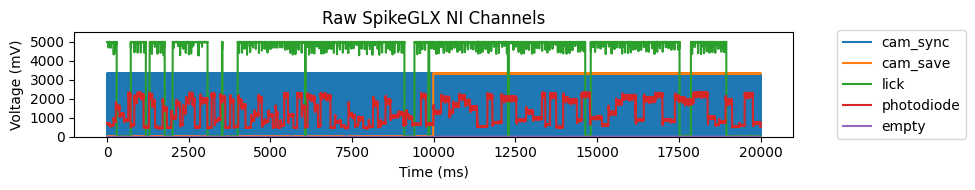

In [13]:
from spike_glx.read_SGLX import read_SGLX, plot_channels_raw

print('Reading SGLX meta and bin files...')
meta, chan_dict = read_SGLX()
print(' Complete.')
print('Plotting channels...')
plot_channels_raw(None, meta, chan_dict, signal_dict, tStart=0, tEnd=20)

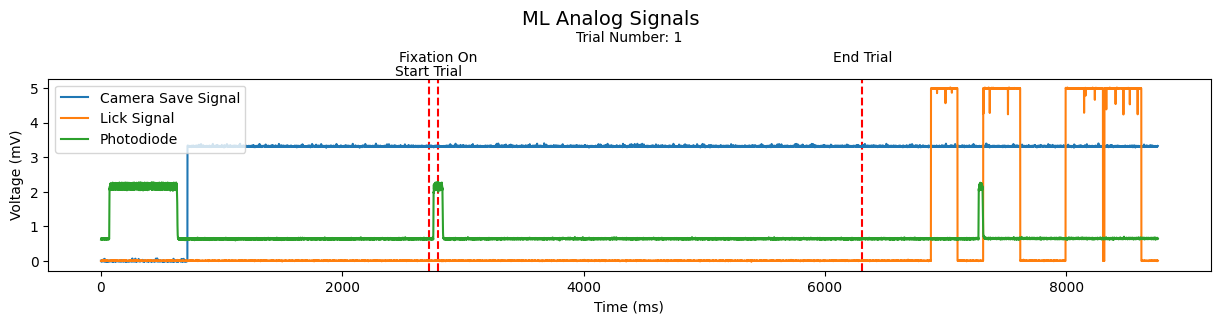

In [5]:
from spike_glx.read_SGLX import plot_analog_ML
# epochs = ['Start Trial', 'Fixation On', 'CS On',	
#           'Trace Start', 'Outcome Start', 'End Trial']
plot_analog_ML(session_obj.df, epochs, trial_num=1)

Pickled spikeglx_obj not found for: aragorn_231106
Generating new spikeglx_obj...
  Looking for SpikeGLX binary and meta file in:
  /Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/data/shared/Aragorn/20231106/aragorn_20231106
Looking for binary file in /Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/data/shared/Aragorn/20231106/aragorn_20231106
Found folder: aragorn_20231106_g0
  Found metadata file: aragorn_20231106_g0_t0.nidq.meta
  Found binary file: aragorn_20231106_g0_t0.nidq.bin
File Name: C:/Users/Penfield/Desktop/Rahim/SpikeGLX/aragorn_20231106_g0/aragorn_20231106_g0_t0.nidq.bin
  Number of Channels: 5
  File Created: 2023-11-06T14:58:20
  File Length: 7335.4755
nChan: 5, nFileSamp: 14670951
Number of Channels:  5
Sample Rate:  2000.0
Number of frames in SpikeGLX Cam TTL: 877704


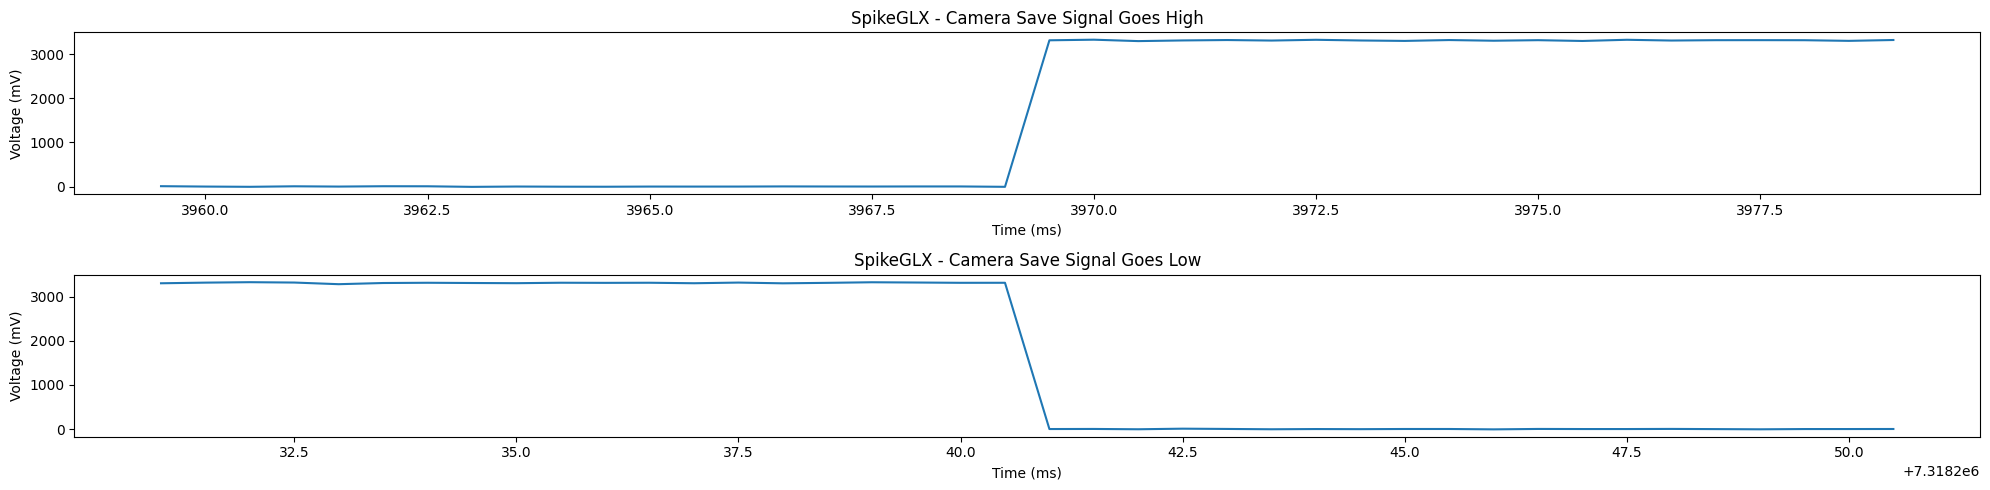

Video Folders:
['231106_Aragorn_145941', '231106_Aragorn_152120', '231106_Aragorn_145824']
Number of cameras: 4
  Camera: e3v831b | Number of videos: 7
  Camera: e3v8360 | Number of videos: 7
  Camera: e3v83ad | Number of videos: 7
  Camera: e3v83d6 | Number of videos: 7
Camera: e3v831b
  Video: e3v831b-20231106T145822-151823.avi | Frames: 144123 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231106T151823-153823.avi | Frames: 144004 | FPS: 120.0 | Length (minutes): 20.0   
  Video: e3v831b-20231106T153823-155823.avi | Frames: 144004 | FPS: 120.0 | Length (minutes): 20.0   
  Video: e3v831b-20231106T155823-161824.avi | Frames: 144123 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231106T161824-163824.avi | Frames: 144005 | FPS: 120.0 | Length (minutes): 20.0   
  Video: e3v831b-20231106T163824-165824.avi | Frames: 144004 | FPS: 120.0 | Length (minutes): 20.0   
  Video: e3v831b-20231106T165824-170016.avi | Frames: 13441  | FPS: 120.0 | Length (minutes): 1.87  

Trial Number:   0%|          | 0/588 [00:00<?, ?it/s]

Trial 1 | Correlation: 0.997 | SGLX High Time: 7939 | ML High Time: 717
  Trial 1 | Epoch start 3252.5 | Epoch end 12013.5
Trial 2 | Correlation: 0.995 | SGLX High Time: 2746 | ML High Time: 1573
  Trial 2 | Epoch start 12013.5 | Epoch end 23259.5
Trial 3 | Correlation: 0.995 | SGLX High Time: 2771 | ML High Time: 1585
  Trial 3 | Epoch start 23260.0 | Epoch end 29916.0
Trial 4 | Correlation: 0.993 | SGLX High Time: 2770 | ML High Time: 1585
  Trial 4 | Epoch start 29916.0 | Epoch end 41071.0
Trial 5 | Correlation: 0.998 | SGLX High Time: 2770 | ML High Time: 1585
  Trial 5 | Epoch start 41071.0 | Epoch end 46716.0
Trial 6 | Correlation: 0.997 | SGLX High Time: 2768 | ML High Time: 1584
  Trial 6 | Epoch start 46716.0 | Epoch end 52383.0
Trial 7 | Correlation: 0.994 | SGLX High Time: 2738 | ML High Time: 1569
  Trial 7 | Epoch start 52383.0 | Epoch end 59982.0
Trial 8 | Correlation: 1.0 | SGLX High Time: 4396 | ML High Time: 2398
  Trial 8 | Epoch start 59982.0 | Epoch end 65288.0
Tria

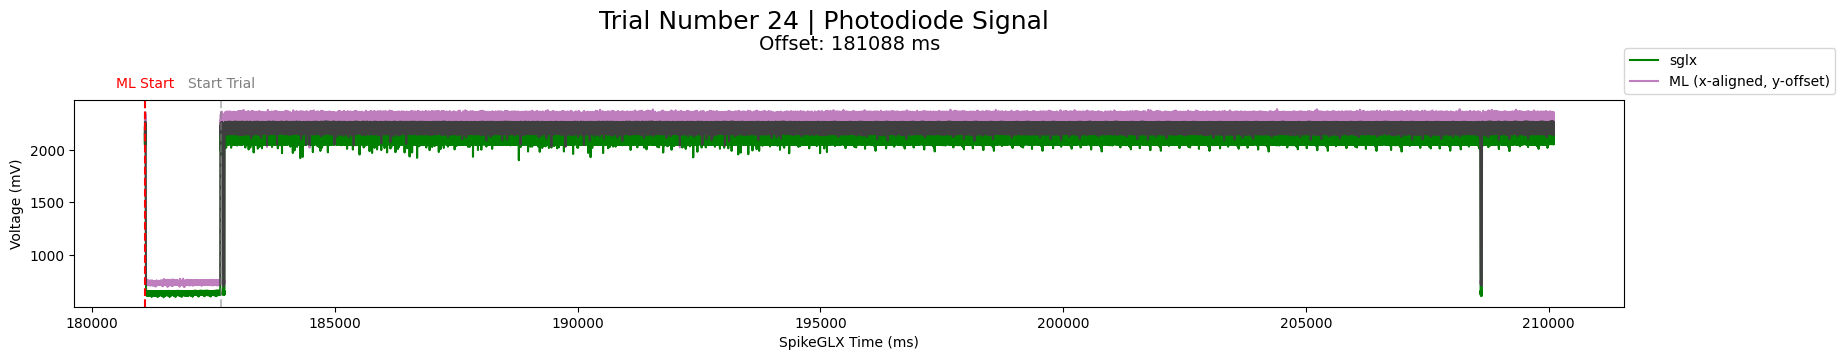

Trial 24:
  ML Cam Start           |  6      
  ML Cam End             |  29015  
  ML Cam Num Frames      |  3482   
  --------------------------------------
  SpikeGLX Trial Start   |  181088.0
  SpikeGLX Trial End     |  210107.0
  SpikeGLX Num Frames    |  3482   
  ML-SGLX Correlation: 0.969
  Trial 25 | Epoch start 210107.0 | Epoch end 263287.0


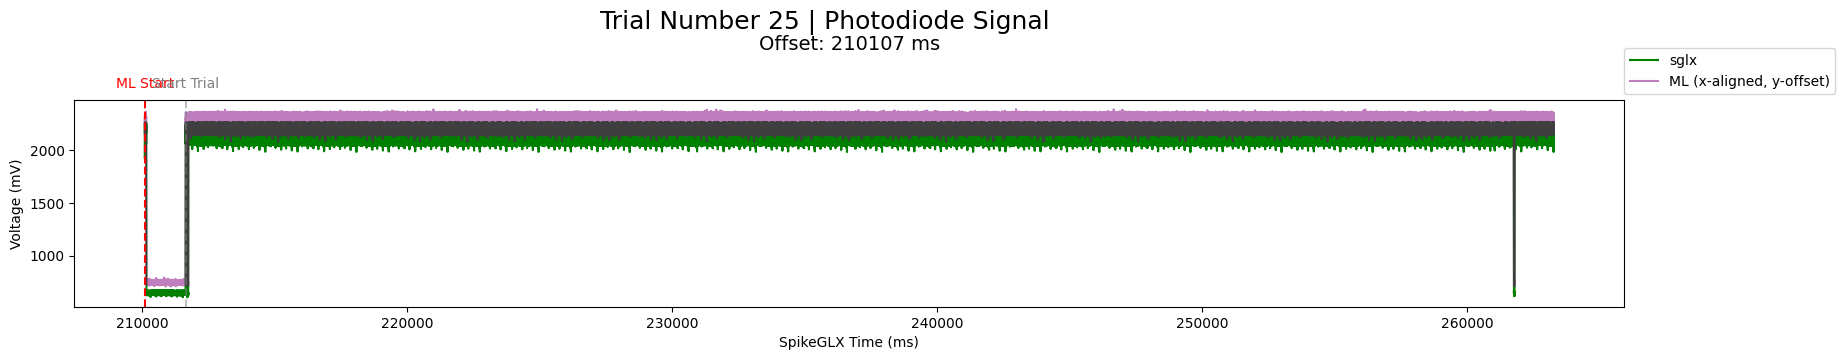

Trial 25:
  ML Cam Start           |  4      
  ML Cam End             |  53179  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  210107.0
  SpikeGLX Trial End     |  263287.0
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.938
Trial 26 | Correlation: 0.996 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 26 | Epoch start 263287.5 | Epoch end 271284.5
Trial 27 | Correlation: 0.996 | SGLX High Time: 4409 | ML High Time: 2404
  Trial 27 | Epoch start 271285.0 | Epoch end 279915.0
Trial 28 | Correlation: 0.995 | SGLX High Time: 4342 | ML High Time: 2371
  Trial 28 | Epoch start 279915.0 | Epoch end 284923.0
Trial 29 | Correlation: 0.994 | SGLX High Time: 2673 | ML High Time: 1537
  Trial 29 | Epoch start 284922.5 | Epoch end 298453.5
Trial 30 | Correlation: 0.995 | SGLX High Time: 2710 | ML High Time: 1555
  Trial 30 | Epoch start 298453.5 | Epoch end 304122.5
Trial 31 | Correlation: 0.995 | SGLX High Time: 2710 | ML

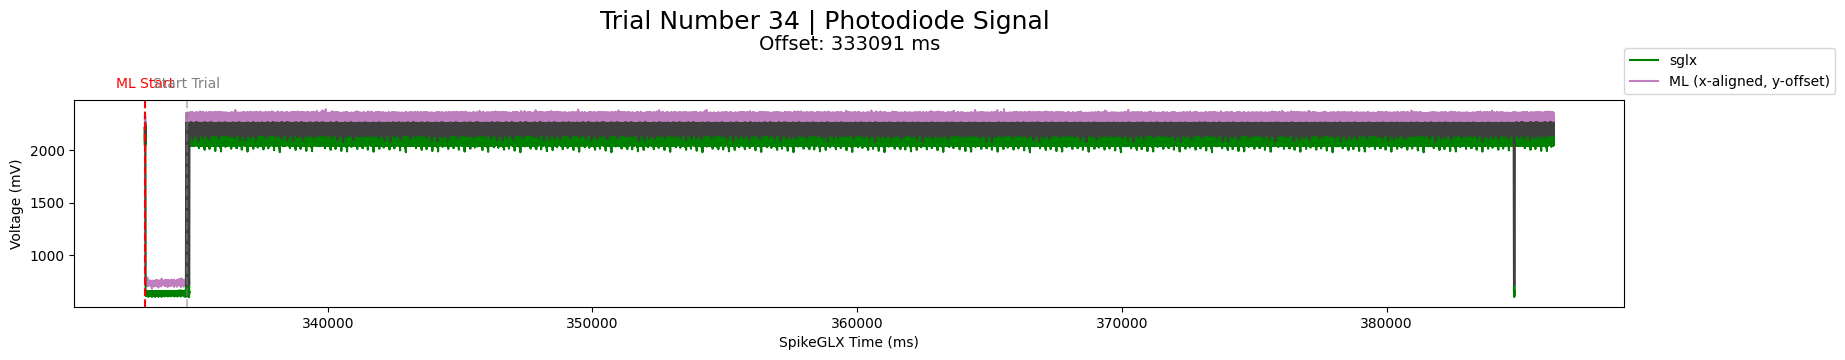

Trial 34:
  ML Cam Start           |  4      
  ML Cam End             |  53221  
  ML Cam Num Frames      |  6387   
  --------------------------------------
  SpikeGLX Trial Start   |  333091.0
  SpikeGLX Trial End     |  386319.0
  SpikeGLX Num Frames    |  6387   
  ML-SGLX Correlation: 0.94
Trial 35 | Correlation: 0.992 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 35 | Epoch start 386320.0 | Epoch end 390146.0
Trial 36 | Correlation: 0.997 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 36 | Epoch start 390146.0 | Epoch end 396690.0
Trial 37 | Correlation: 0.994 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 37 | Epoch start 396690.5 | Epoch end 400898.5
Trial 38 | Correlation: 0.999 | SGLX High Time: 2673 | ML High Time: 1537
  Trial 38 | Epoch start 400898.0 | Epoch end 405572.0
Trial 39 | Correlation: 0.994 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 39 | Epoch start 405572.5 | Epoch end 413162.5
Trial 40 | Correlation: 0.995 | SGLX High Time: 4354 | ML 

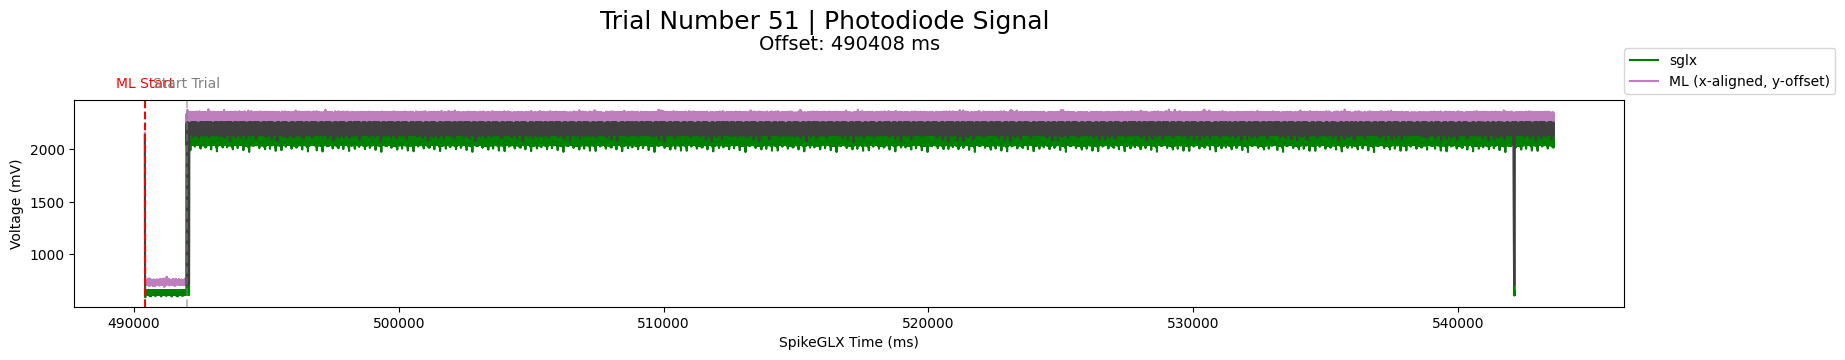

Trial 51:
  ML Cam Start           |  6      
  ML Cam End             |  53214  
  ML Cam Num Frames      |  6386   
  --------------------------------------
  SpikeGLX Trial Start   |  490408.0
  SpikeGLX Trial End     |  543627.0
  SpikeGLX Num Frames    |  6386   
  ML-SGLX Correlation: 0.941
Trial 52 | Correlation: 0.988 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 52 | Epoch start 543628.0 | Epoch end 561409.0
Trial 53 | Correlation: 0.993 | SGLX High Time: 2709 | ML High Time: 1555
  Trial 53 | Epoch start 561408.5 | Epoch end 565671.5
Trial 54 | Correlation: 0.995 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 54 | Epoch start 565672.5 | Epoch end 573204.5
Trial 55 | Correlation: 0.995 | SGLX High Time: 4312 | ML High Time: 2357
  Trial 55 | Epoch start 573203.5 | Epoch end 584951.5
Trial 56 | Correlation: 0.997 | SGLX High Time: 2741 | ML High Time: 1570
  Trial 56 | Epoch start 584952.0 | Epoch end 592582.0
Trial 57 | Correlation: 0.996 | SGLX High Time: 4374 | ML

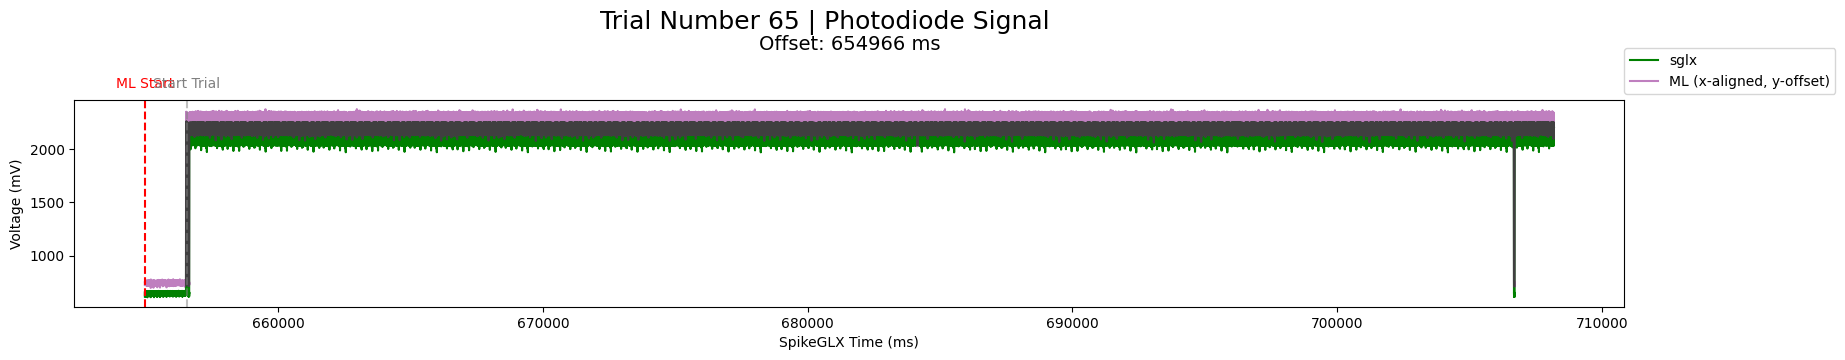

Trial 65:
  ML Cam Start           |  8      
  ML Cam End             |  53217  
  ML Cam Num Frames      |  6386   
  --------------------------------------
  SpikeGLX Trial Start   |  654965.5
  SpikeGLX Trial End     |  708184.5
  SpikeGLX Num Frames    |  6387   
  ML-SGLX Correlation: 0.94
  Trial 66 | Epoch start 708185.0 | Epoch end 761361.0


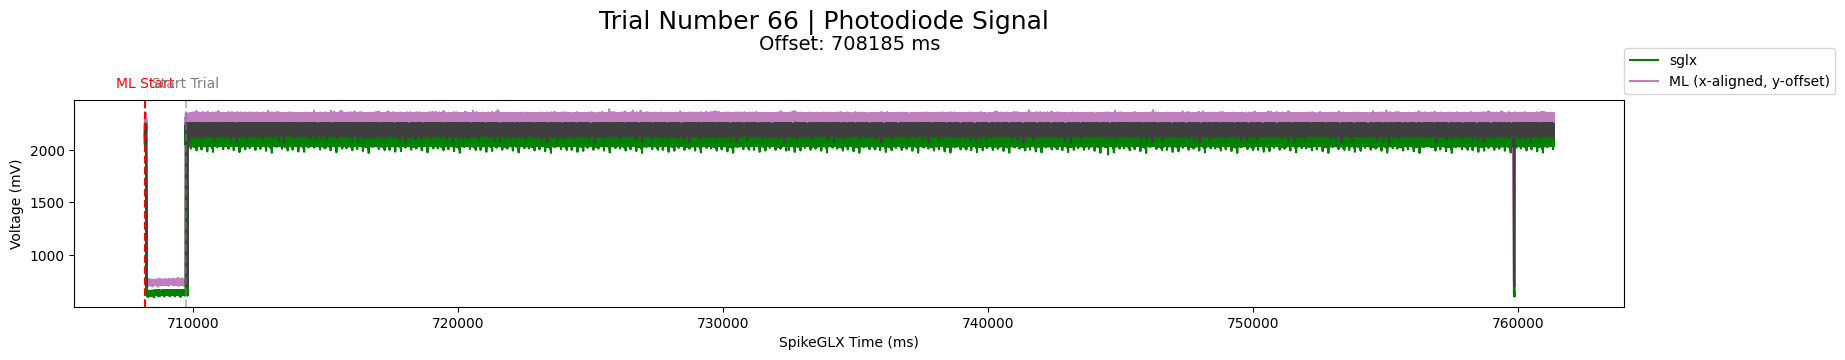

Trial 66:
  ML Cam Start           |  6      
  ML Cam End             |  53173  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  708185.0
  SpikeGLX Trial End     |  761361.0
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.937
  Trial 67 | Epoch start 761361.5 | Epoch end 814543.5


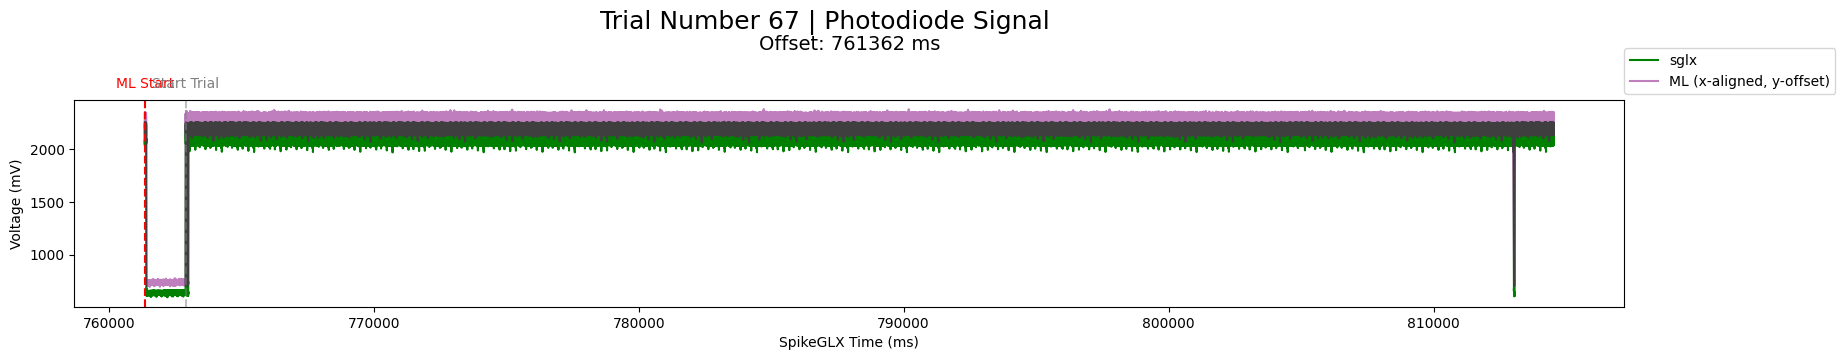

Trial 67:
  ML Cam Start           |  5      
  ML Cam End             |  53180  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  761361.5
  SpikeGLX Trial End     |  814543.5
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.938
Trial 68 | Correlation: 0.991 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 68 | Epoch start 814543.5 | Epoch end 822105.5
Trial 69 | Correlation: 0.996 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 69 | Epoch start 822106.0 | Epoch end 829789.0
Trial 70 | Correlation: 0.995 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 70 | Epoch start 829789.0 | Epoch end 840889.0
Trial 71 | Correlation: 0.996 | SGLX High Time: 2751 | ML High Time: 1575
  Trial 71 | Epoch start 840889.5 | Epoch end 846513.5
Trial 72 | Correlation: 0.998 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 72 | Epoch start 846513.5 | Epoch end 853075.5
Trial 73 | Correlation: 0.997 | SGLX High Time: 2709 | ML

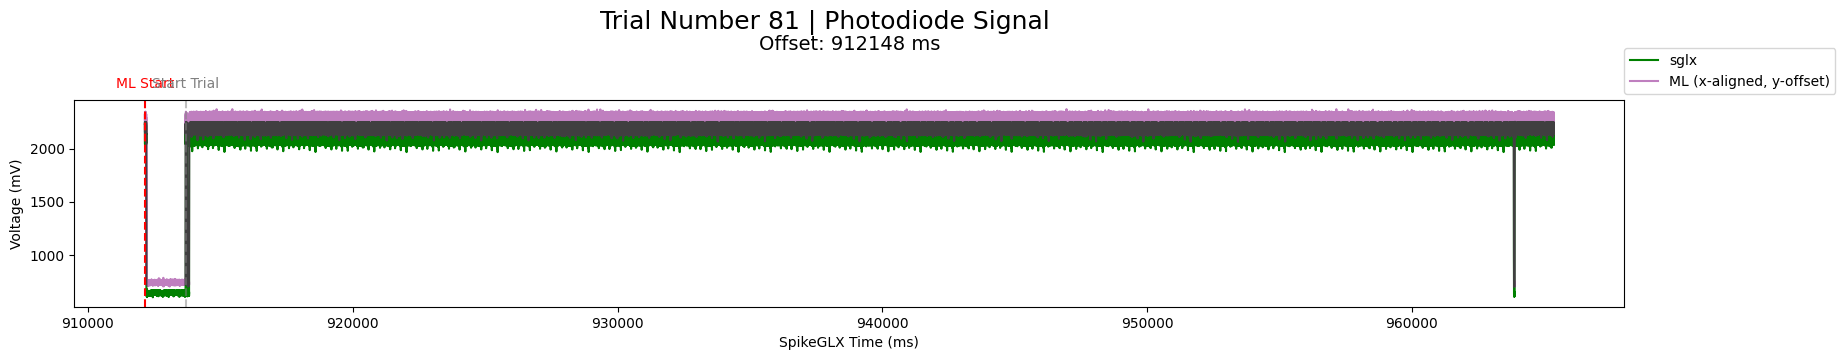

Trial 81:
  ML Cam Start           |  3      
  ML Cam End             |  53211  
  ML Cam Num Frames      |  6386   
  --------------------------------------
  SpikeGLX Trial Start   |  912148.5
  SpikeGLX Trial End     |  965362.5
  SpikeGLX Num Frames    |  6386   
  ML-SGLX Correlation: 0.939
Trial 82 | Correlation: 0.985 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 82 | Epoch start 965363.0 | Epoch end 990988.0
Trial 83 | Correlation: 0.994 | SGLX High Time: 2740 | ML High Time: 1570
  Trial 83 | Epoch start 990988.0 | Epoch end 998734.0
Trial 84 | Correlation: 0.996 | SGLX High Time: 4376 | ML High Time: 2387
  Trial 84 | Epoch start 998735.0 | Epoch end 1005187.0
Trial 85 | Correlation: 0.996 | SGLX High Time: 2740 | ML High Time: 1570
  Trial 85 | Epoch start 1005187.0 | Epoch end 1011764.0
Trial 86 | Correlation: 0.997 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 86 | Epoch start 1011764.0 | Epoch end 1019422.0
Trial 87 | Correlation: 0.997 | SGLX High Time: 4398

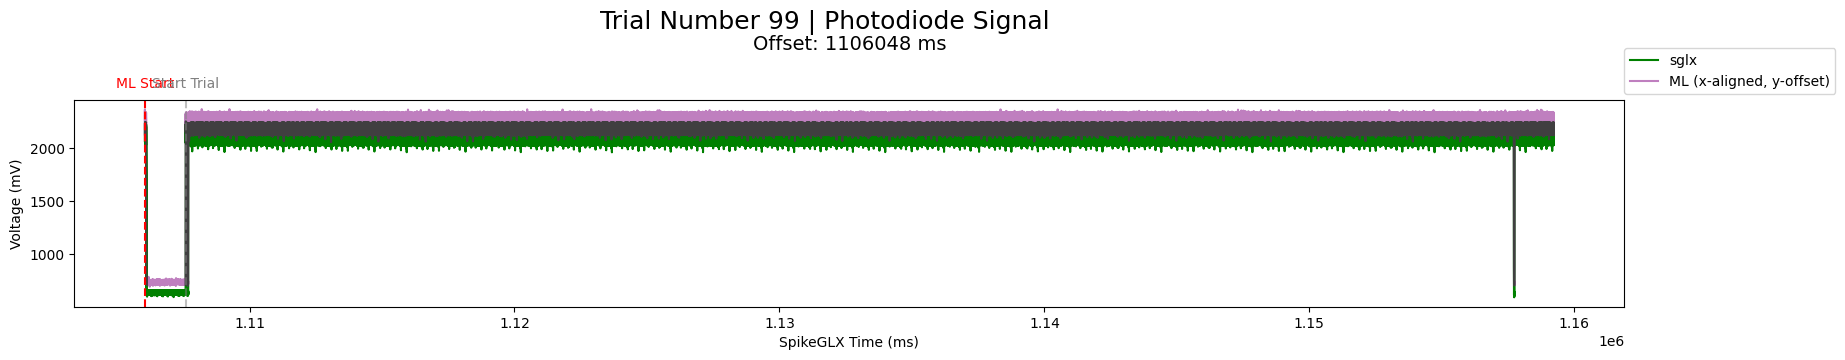

Trial 99:
  ML Cam Start           |  5      
  ML Cam End             |  53180  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  1106048.5
  SpikeGLX Trial End     |  1159233.5
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.94
Trial 100 | Correlation: 0.992 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 100 | Epoch start 1159234.0 | Epoch end 1171504.0
Trial 101 | Correlation: 0.998 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 101 | Epoch start 1171504.5 | Epoch end 1175731.5
Trial 102 | Correlation: 0.992 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 102 | Epoch start 1175731.5 | Epoch end 1179621.5
  Trial 103 | Epoch start 1179621.5 | Epoch end 1232807.5


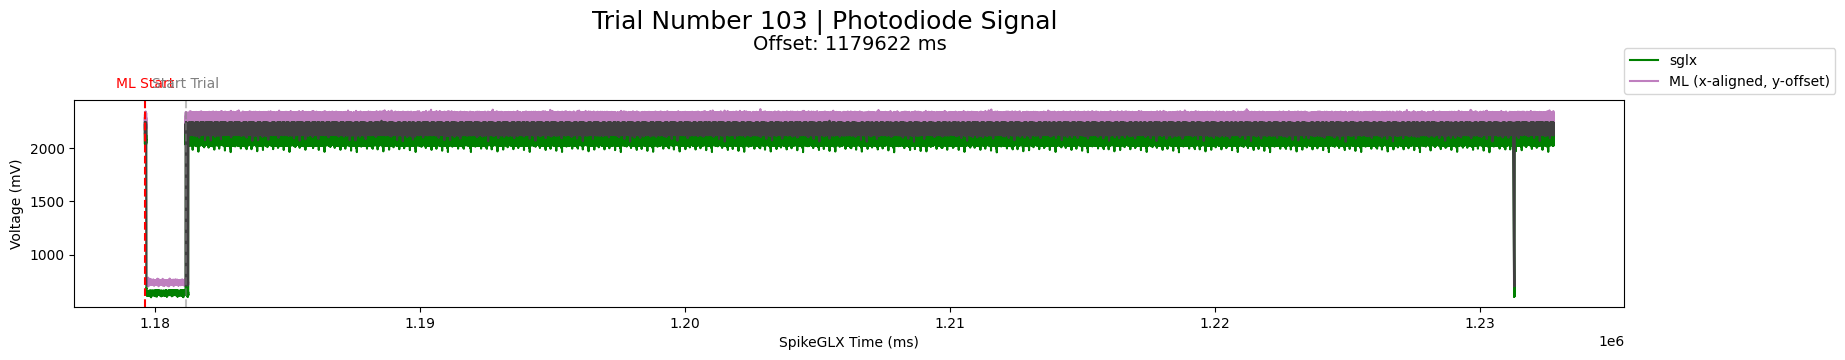

Trial 103:
  ML Cam Start           |  8      
  ML Cam End             |  53183  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  1179621.5
  SpikeGLX Trial End     |  1232807.5
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.94
  Trial 104 | Epoch start 1232808.0 | Epoch end 1285978.0


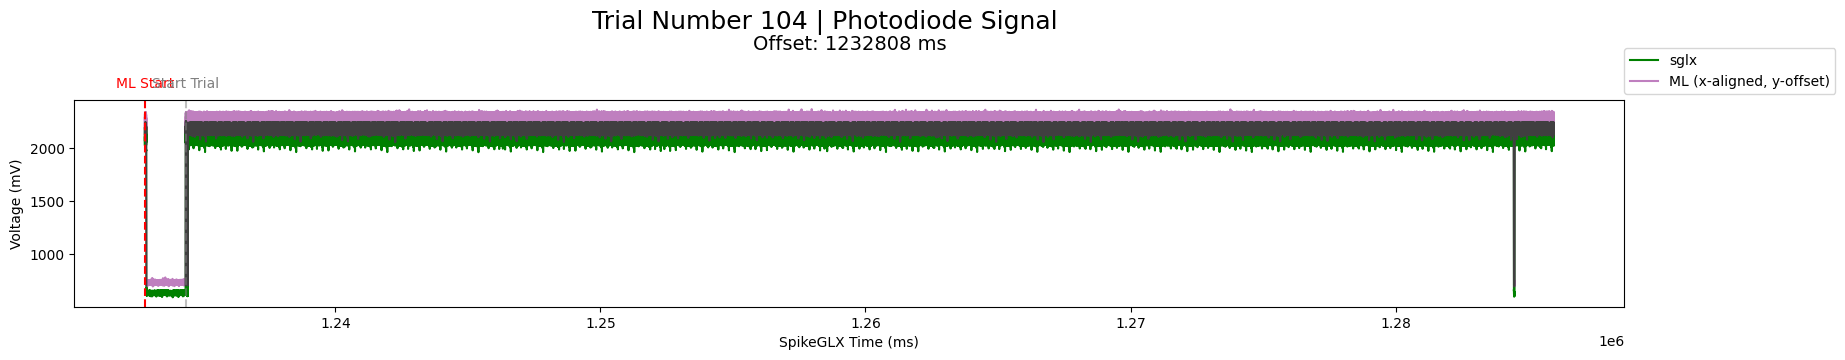

Trial 104:
  ML Cam Start           |  5      
  ML Cam End             |  53163  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  1232808.0
  SpikeGLX Trial End     |  1285978.0
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.94
  Trial 105 | Epoch start 1285978.5 | Epoch end 1339152.5


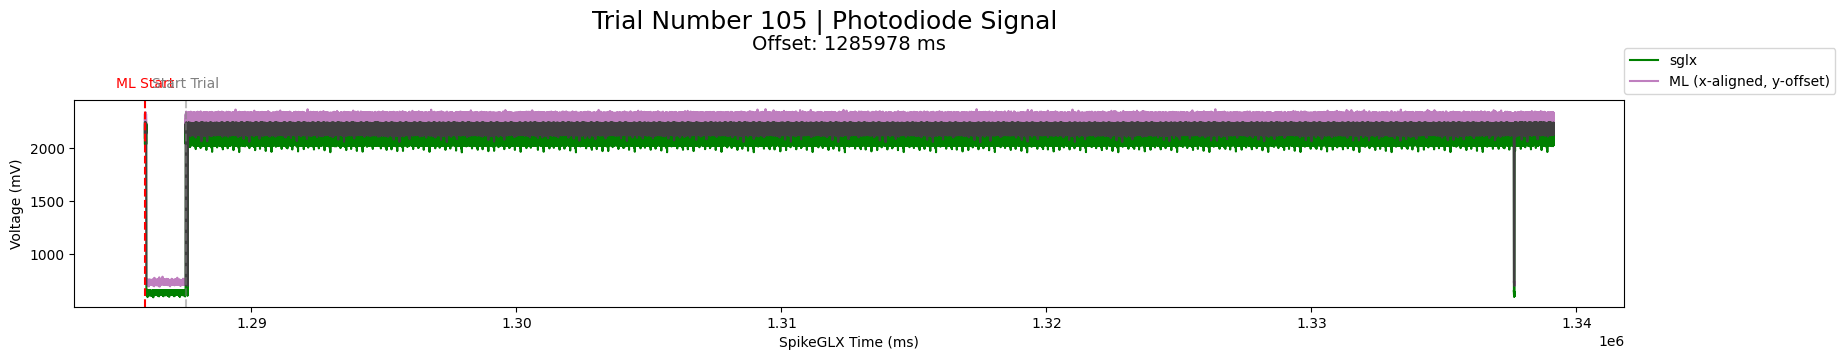

Trial 105:
  ML Cam Start           |  2      
  ML Cam End             |  53168  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  1285978.5
  SpikeGLX Trial End     |  1339152.5
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.939
Trial 106 | Correlation: 0.995 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 106 | Epoch start 1339153.5 | Epoch end 1349502.5
Trial 107 | Correlation: 0.994 | SGLX High Time: 2709 | ML High Time: 1555
  Trial 107 | Epoch start 1349502.0 | Epoch end 1357086.0
Trial 108 | Correlation: 0.996 | SGLX High Time: 4356 | ML High Time: 2378
  Trial 108 | Epoch start 1357086.0 | Epoch end 1364575.0
Trial 109 | Correlation: 0.995 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 109 | Epoch start 1364576.0 | Epoch end 1371192.0
Trial 110 | Correlation: 0.995 | SGLX High Time: 2708 | ML High Time: 1555
  Trial 110 | Epoch start 1371191.0 | Epoch end 1377807.0
Trial 111 | Correlation: 0.997 | S

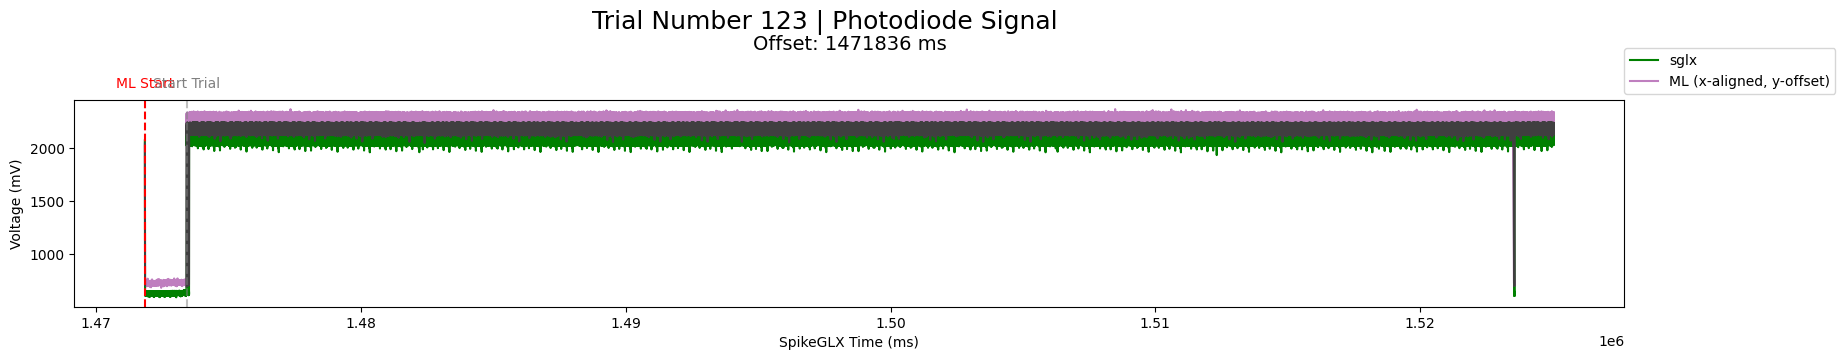

Trial 123:
  ML Cam Start           |  4      
  ML Cam End             |  53212  
  ML Cam Num Frames      |  6386   
  --------------------------------------
  SpikeGLX Trial Start   |  1471836.5
  SpikeGLX Trial End     |  1525056.5
  SpikeGLX Num Frames    |  6386   
  ML-SGLX Correlation: 0.944
  Trial 124 | Epoch start 1525057.0 | Epoch end 1578229.0


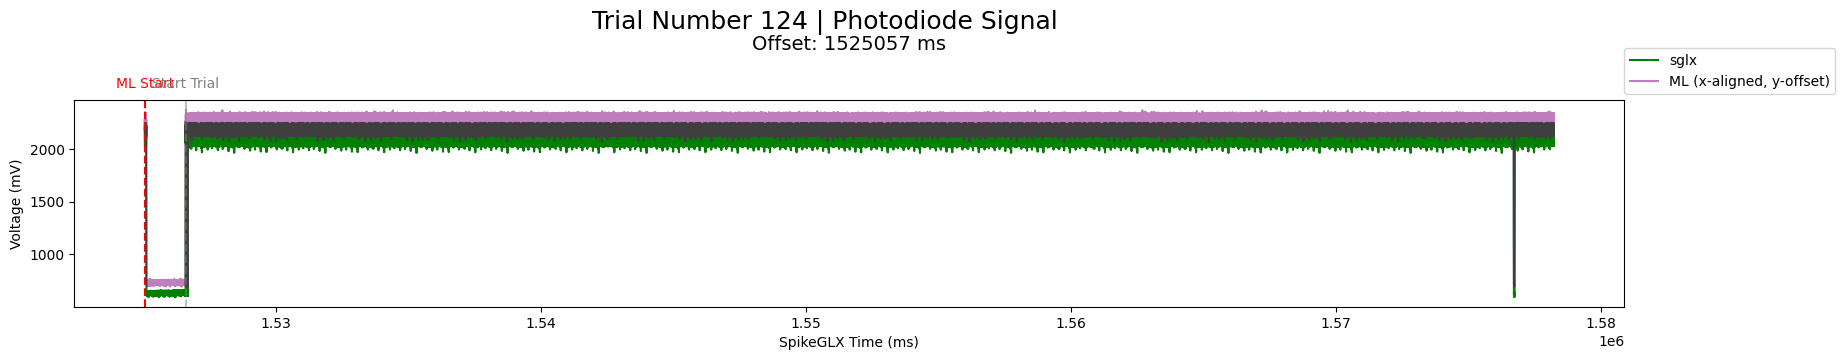

Trial 124:
  ML Cam Start           |  1      
  ML Cam End             |  53167  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  1525057.0
  SpikeGLX Trial End     |  1578229.0
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.94
  Trial 125 | Epoch start 1578229.5 | Epoch end 1626127.5


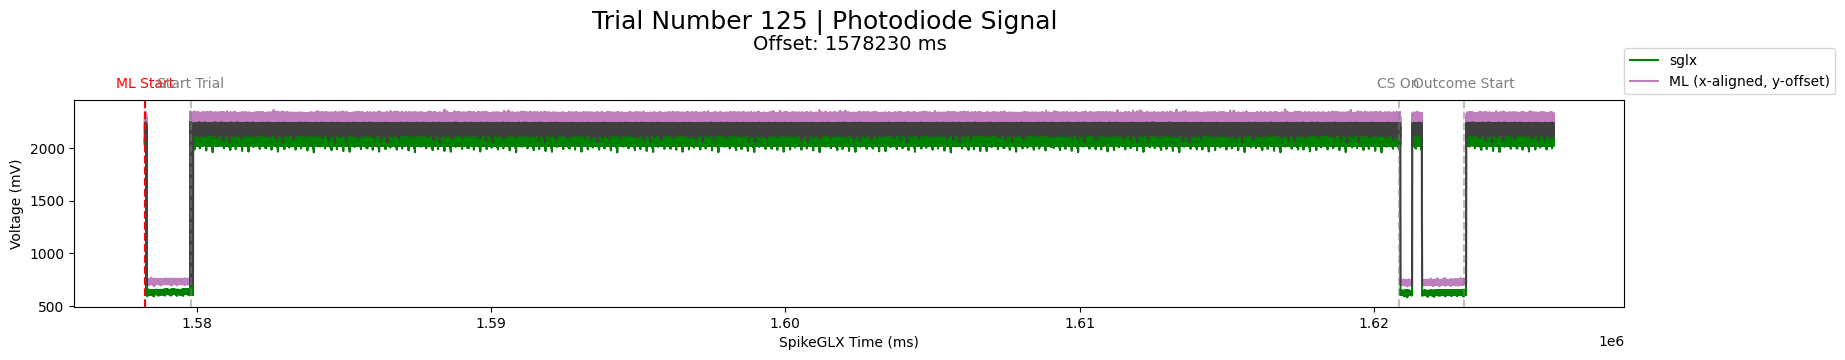

Trial 125:
  ML Cam Start           |  4      
  ML Cam End             |  47895  
  ML Cam Num Frames      |  5748   
  --------------------------------------
  SpikeGLX Trial Start   |  1578229.5
  SpikeGLX Trial End     |  1626127.5
  SpikeGLX Num Frames    |  5748   
  ML-SGLX Correlation: 0.973
Trial 126 | Correlation: 0.995 | SGLX High Time: 4480 | ML High Time: 2440
  Trial 126 | Epoch start 1626127.5 | Epoch end 1634614.5
Trial 127 | Correlation: 0.998 | SGLX High Time: 4343 | ML High Time: 2371
  Trial 127 | Epoch start 1634615.0 | Epoch end 1642047.0
Trial 128 | Correlation: 0.995 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 128 | Epoch start 1642047.0 | Epoch end 1649647.0
Trial 129 | Correlation: 0.997 | SGLX High Time: 4355 | ML High Time: 2377
  Trial 129 | Epoch start 1649647.5 | Epoch end 1656969.5
Trial 130 | Correlation: 0.998 | SGLX High Time: 2707 | ML High Time: 1554
  Trial 130 | Epoch start 1656969.0 | Epoch end 1662650.0
Trial 131 | Correlation: 0.996 | S

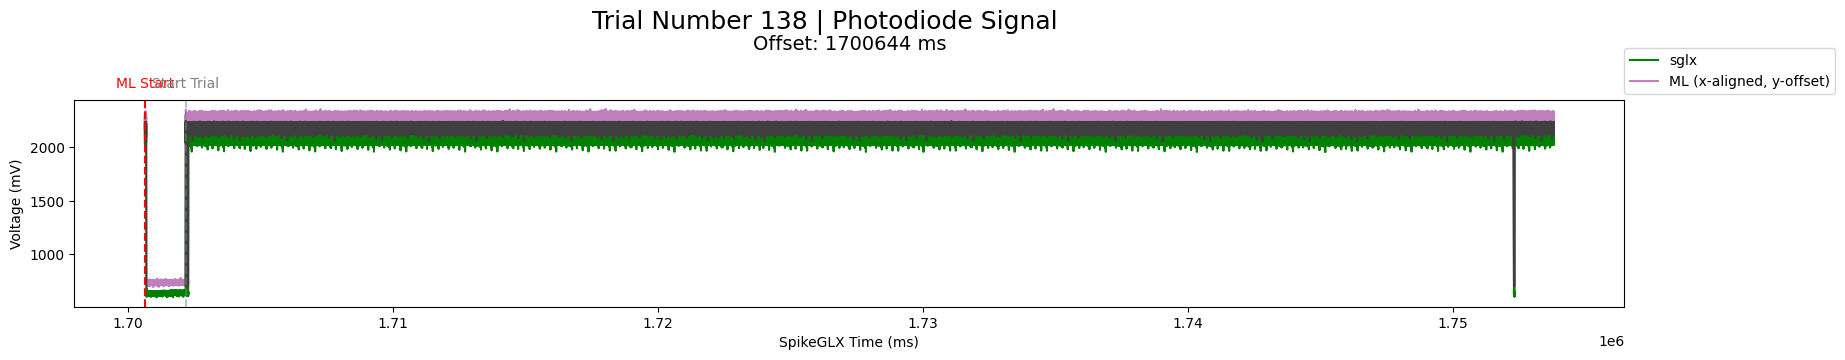

Trial 138:
  ML Cam Start           |  7      
  ML Cam End             |  53174  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  1700644.0
  SpikeGLX Trial End     |  1753822.0
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.94
  Trial 139 | Epoch start 1753822.5 | Epoch end 1807009.5


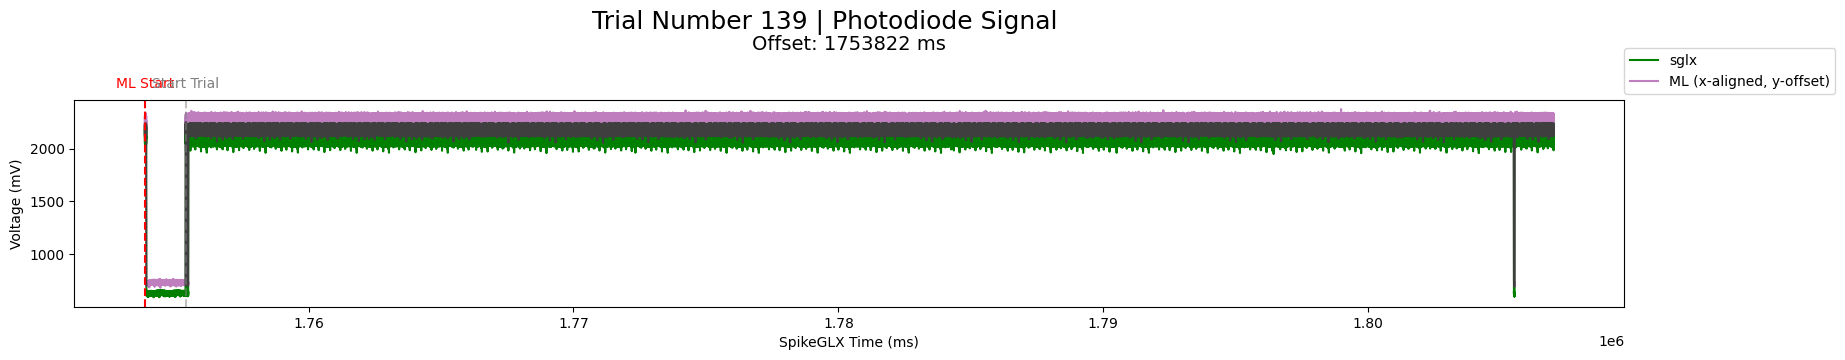

Trial 139:
  ML Cam Start           |  4      
  ML Cam End             |  53179  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  1753822.5
  SpikeGLX Trial End     |  1807009.5
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.941
  Trial 140 | Epoch start 1807010.0 | Epoch end 1860236.0


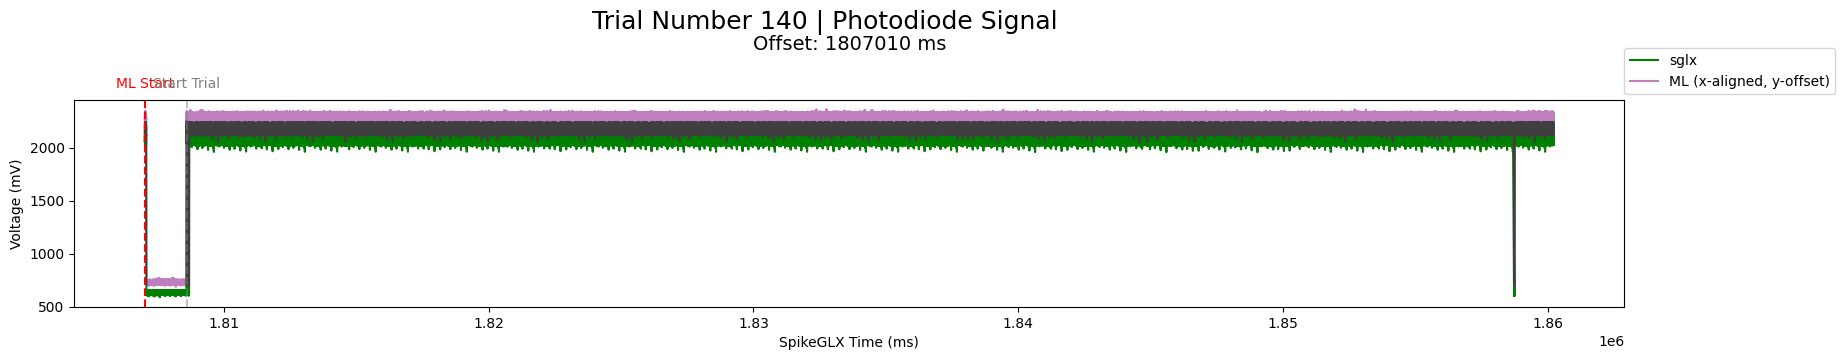

Trial 140:
  ML Cam Start           |  1      
  ML Cam End             |  53217  
  ML Cam Num Frames      |  6387   
  --------------------------------------
  SpikeGLX Trial Start   |  1807010.0
  SpikeGLX Trial End     |  1860236.0
  SpikeGLX Num Frames    |  6388   
  ML-SGLX Correlation: 0.941
  Trial 141 | Epoch start 1860236.5 | Epoch end 1913409.5


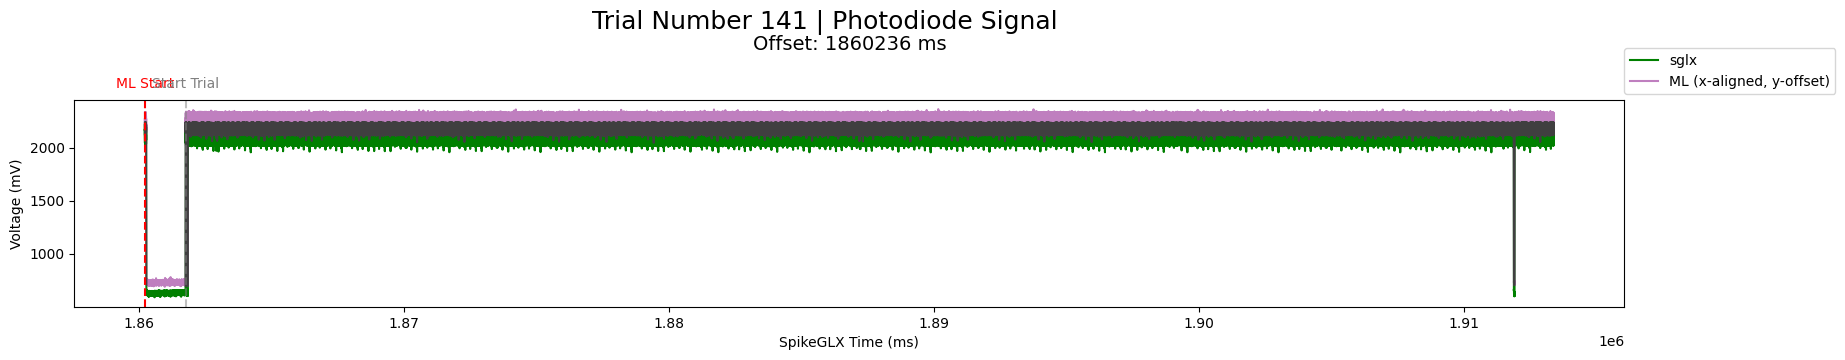

Trial 141:
  ML Cam Start           |  8      
  ML Cam End             |  53166  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  1860236.5
  SpikeGLX Trial End     |  1913409.5
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.939
  Trial 142 | Epoch start 1913410.0 | Epoch end 1957406.0


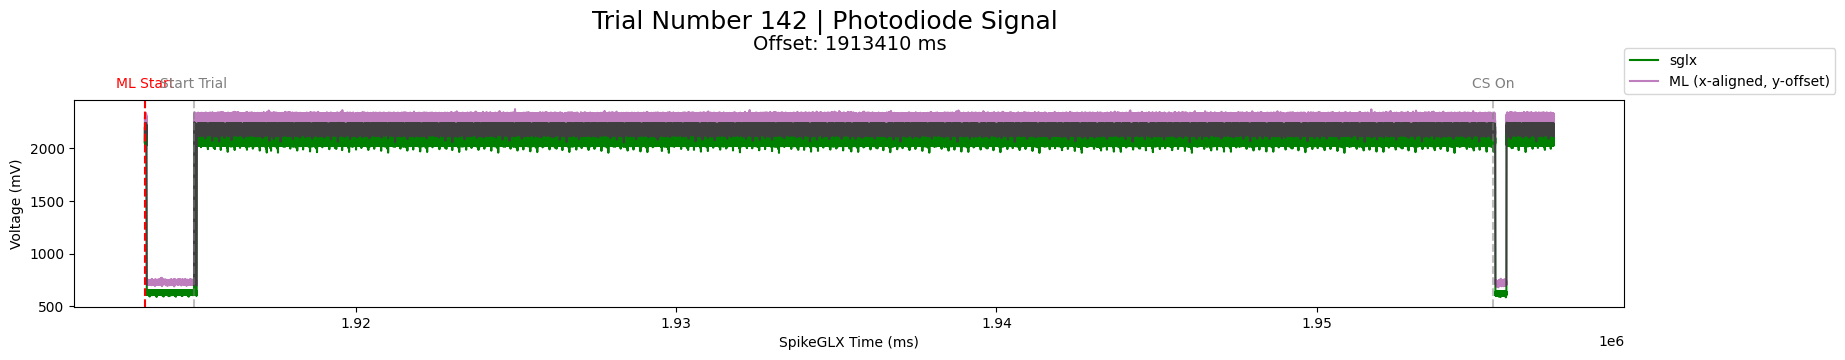

Trial 142:
  ML Cam Start           |  2      
  ML Cam End             |  43993  
  ML Cam Num Frames      |  5280   
  --------------------------------------
  SpikeGLX Trial Start   |  1913410.0
  SpikeGLX Trial End     |  1957406.0
  SpikeGLX Num Frames    |  5280   
  ML-SGLX Correlation: 0.956
Trial 143 | Correlation: 0.998 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 143 | Epoch start 1957406.0 | Epoch end 1963032.0
Trial 144 | Correlation: 0.994 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 144 | Epoch start 1963032.5 | Epoch end 1974226.5
Trial 145 | Correlation: 0.995 | SGLX High Time: 2773 | ML High Time: 1587
  Trial 145 | Epoch start 1974226.0 | Epoch end 1985382.0
Trial 146 | Correlation: 0.995 | SGLX High Time: 2741 | ML High Time: 1570
  Trial 146 | Epoch start 1985382.5 | Epoch end 1991960.5
Trial 147 | Correlation: 0.998 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 147 | Epoch start 1991961.0 | Epoch end 1998612.0
Trial 148 | Correlation: 0.995 | S

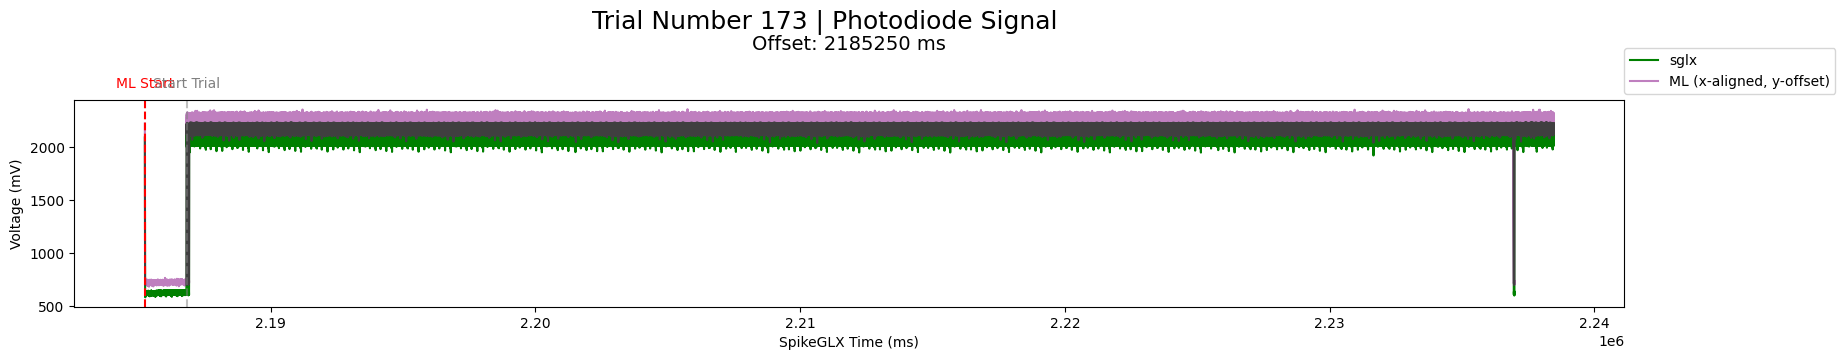

Trial 173:
  ML Cam Start           |  5      
  ML Cam End             |  53222  
  ML Cam Num Frames      |  6387   
  --------------------------------------
  SpikeGLX Trial Start   |  2185250.0
  SpikeGLX Trial End     |  2238474.0
  SpikeGLX Num Frames    |  6387   
  ML-SGLX Correlation: 0.943
  Trial 174 | Epoch start 2238474.5 | Epoch end 2291656.5


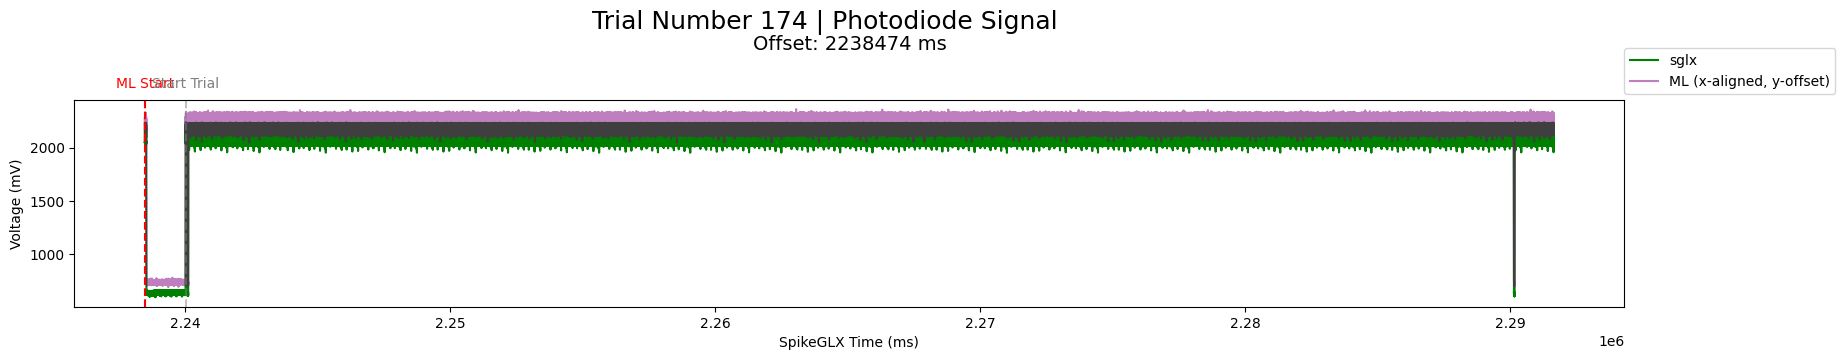

Trial 174:
  ML Cam Start           |  6      
  ML Cam End             |  53181  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  2238474.5
  SpikeGLX Trial End     |  2291656.5
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.94
  Trial 175 | Epoch start 2291657.5 | Epoch end 2314793.5


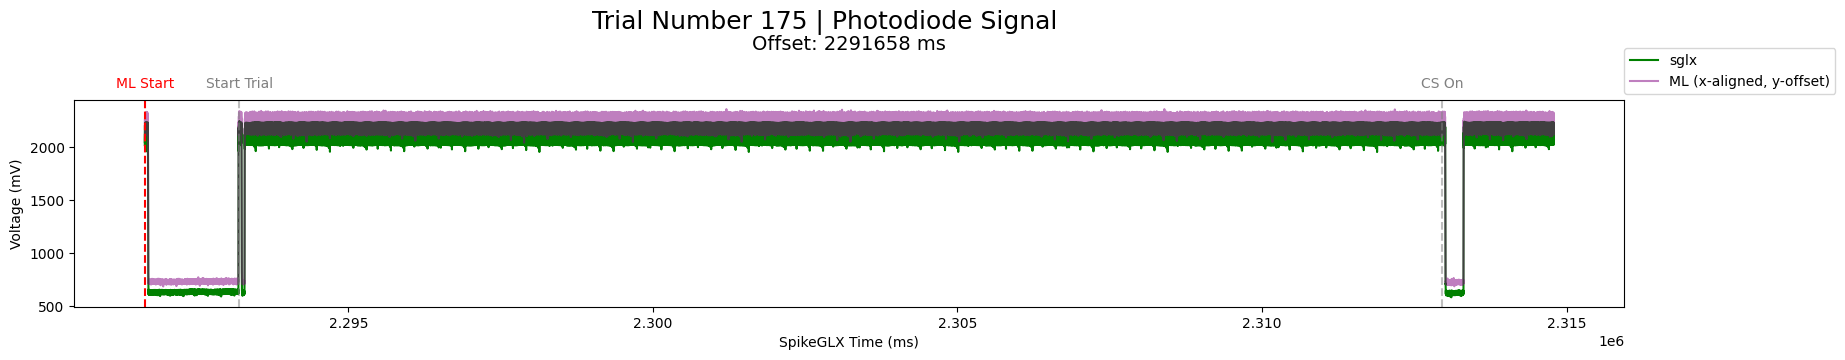

Trial 175:
  ML Cam Start           |  8      
  ML Cam End             |  23133  
  ML Cam Num Frames      |  2776   
  --------------------------------------
  SpikeGLX Trial Start   |  2291657.5
  SpikeGLX Trial End     |  2314793.5
  SpikeGLX Num Frames    |  2776   
  ML-SGLX Correlation: 0.978
Trial 176 | Correlation: 0.995 | SGLX High Time: 2673 | ML High Time: 1537
  Trial 176 | Epoch start 2314793.0 | Epoch end 2322406.0
Trial 177 | Correlation: 0.997 | SGLX High Time: 4408 | ML High Time: 2403
  Trial 177 | Epoch start 2322407.0 | Epoch end 2330908.0
Trial 178 | Correlation: 0.997 | SGLX High Time: 4341 | ML High Time: 2371
  Trial 178 | Epoch start 2330907.5 | Epoch end 2338101.5
Trial 179 | Correlation: 0.994 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 179 | Epoch start 2338102.5 | Epoch end 2345740.5
Trial 180 | Correlation: 0.995 | SGLX High Time: 4306 | ML High Time: 2354
  Trial 180 | Epoch start 2345739.5 | Epoch end 2353117.5
Trial 181 | Correlation: 0.993 | S

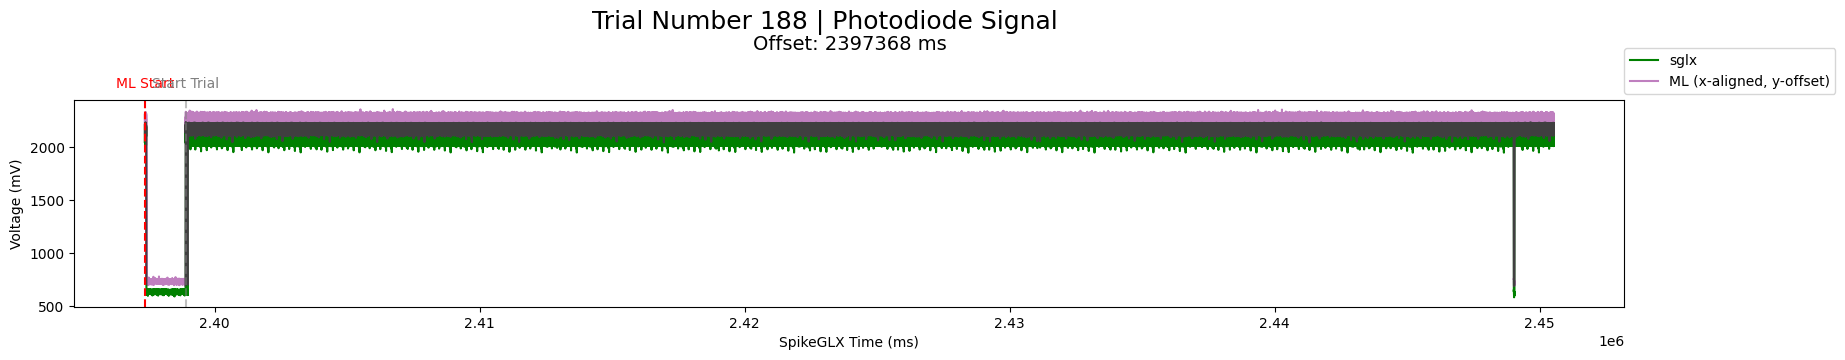

Trial 188:
  ML Cam Start           |  6      
  ML Cam End             |  53173  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  2397368.0
  SpikeGLX Trial End     |  2450543.0
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.936
Trial 189 | Correlation: 0.99 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 189 | Epoch start 2450543.5 | Epoch end 2464388.5
Trial 190 | Correlation: 0.997 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 190 | Epoch start 2464388.5 | Epoch end 2471025.5
Trial 191 | Correlation: 0.994 | SGLX High Time: 2740 | ML High Time: 1569
  Trial 191 | Epoch start 2471026.5 | Epoch end 2478705.5
Trial 192 | Correlation: 0.996 | SGLX High Time: 4341 | ML High Time: 2371
  Trial 192 | Epoch start 2478705.0 | Epoch end 2484915.0
Trial 193 | Correlation: 0.997 | SGLX High Time: 2740 | ML High Time: 1570
  Trial 193 | Epoch start 2484915.0 | Epoch end 2492544.0
Trial 194 | Correlation: 0.997 | SG

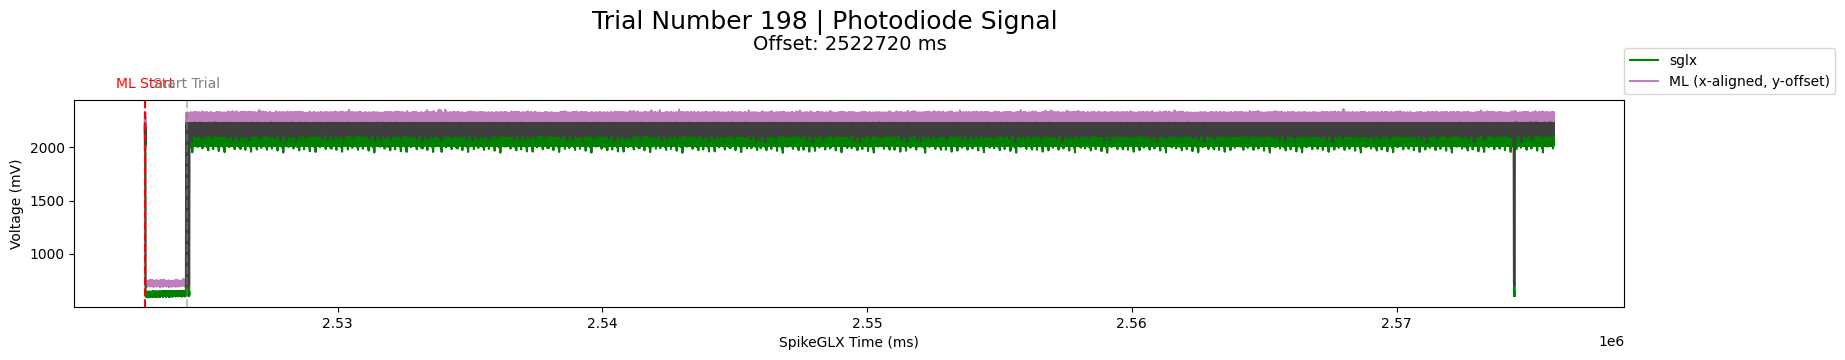

Trial 198:
  ML Cam Start           |  6      
  ML Cam End             |  53223  
  ML Cam Num Frames      |  6387   
  --------------------------------------
  SpikeGLX Trial Start   |  2522719.5
  SpikeGLX Trial End     |  2575947.5
  SpikeGLX Num Frames    |  6387   
  ML-SGLX Correlation: 0.94
  Trial 199 | Epoch start 2575948.5 | Epoch end 2629110.5


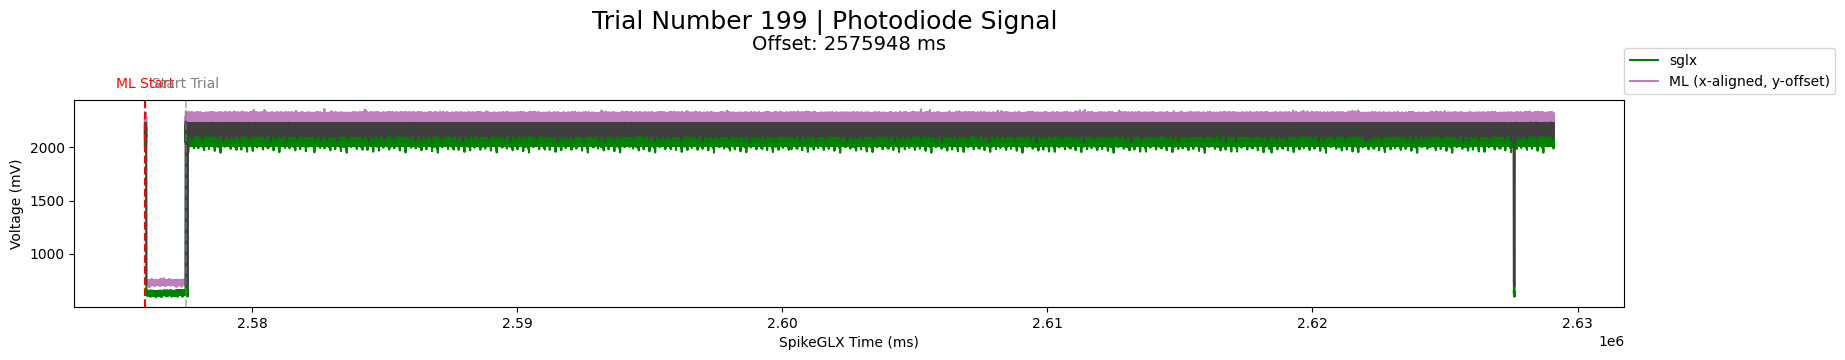

Trial 199:
  ML Cam Start           |  3      
  ML Cam End             |  53153  
  ML Cam Num Frames      |  6379   
  --------------------------------------
  SpikeGLX Trial Start   |  2575948.5
  SpikeGLX Trial End     |  2629110.5
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.938
  Trial 200 | Epoch start 2629111.0 | Epoch end 2682301.0


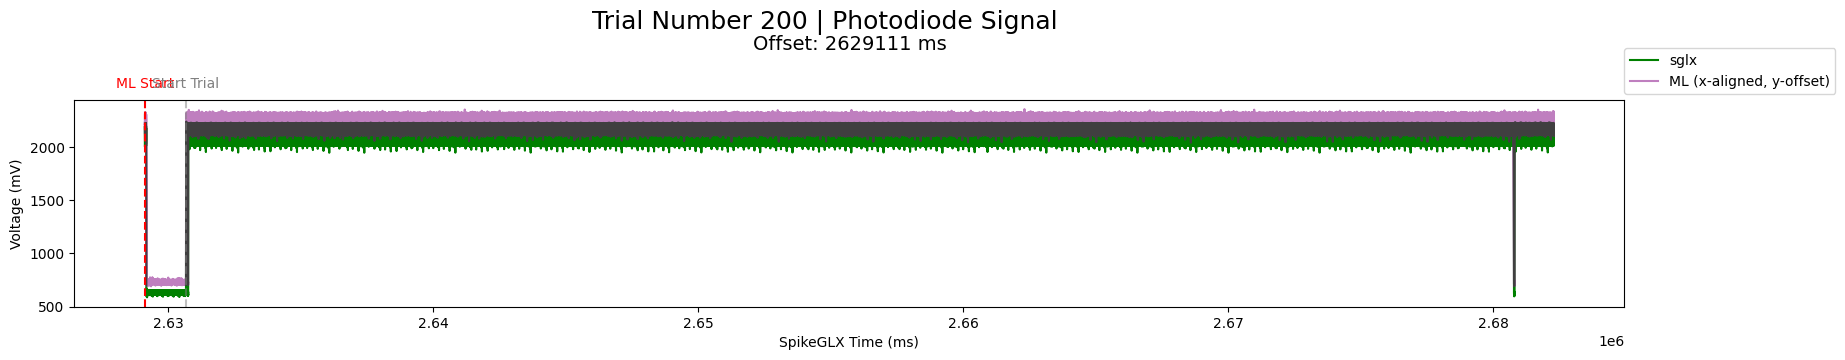

Trial 200:
  ML Cam Start           |  8      
  ML Cam End             |  53183  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  2629111.0
  SpikeGLX Trial End     |  2682301.0
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.937
Trial 201 | Correlation: 0.981 | SGLX High Time: 2673 | ML High Time: 1537
  Trial 201 | Epoch start 2682300.5 | Epoch end 2717666.5
Trial 202 | Correlation: 0.998 | SGLX High Time: 2711 | ML High Time: 1554
  Trial 202 | Epoch start 2717668.0 | Epoch end 2724217.0
Trial 203 | Correlation: 0.998 | SGLX High Time: 2707 | ML High Time: 1554
  Trial 203 | Epoch start 2724216.5 | Epoch end 2731620.5
Trial 204 | Correlation: 0.995 | SGLX High Time: 4397 | ML High Time: 2398
  Trial 204 | Epoch start 2731621.0 | Epoch end 2739266.0
Trial 205 | Correlation: 0.992 | SGLX High Time: 2708 | ML High Time: 1555
  Trial 205 | Epoch start 2739265.0 | Epoch end 2743496.0
Trial 206 | Correlation: 0.994 | S

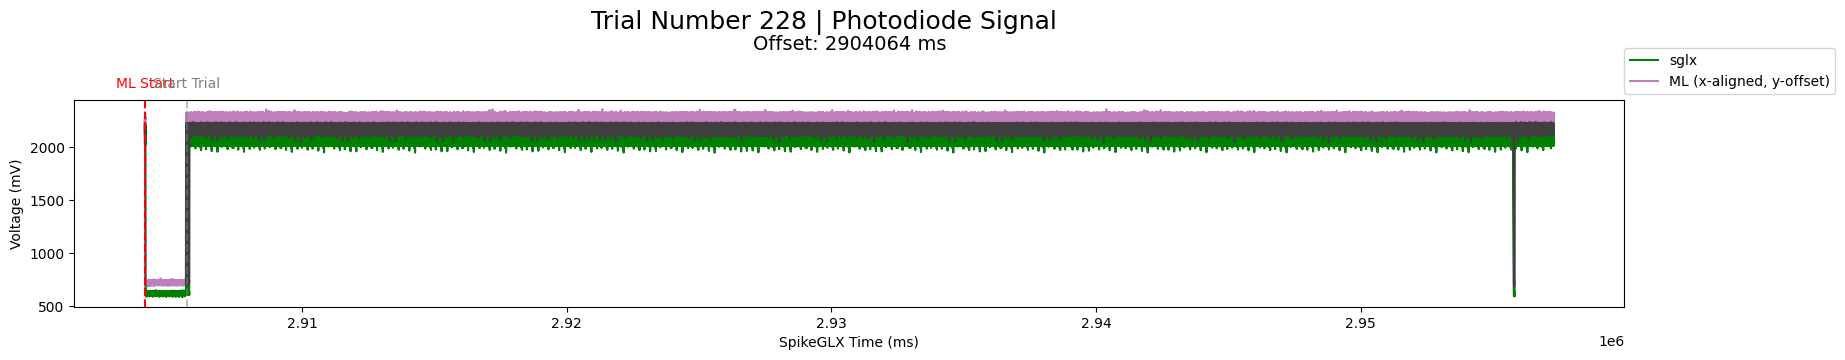

Trial 228:
  ML Cam Start           |  7      
  ML Cam End             |  53232  
  ML Cam Num Frames      |  6388   
  --------------------------------------
  SpikeGLX Trial Start   |  2904064.5
  SpikeGLX Trial End     |  2957297.5
  SpikeGLX Num Frames    |  6388   
  ML-SGLX Correlation: 0.943
Trial 229 | Correlation: 0.985 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 229 | Epoch start 2957297.5 | Epoch end 2981868.5
Trial 230 | Correlation: 0.995 | SGLX High Time: 4440 | ML High Time: 2419
  Trial 230 | Epoch start 2981869.5 | Epoch end 2988336.5
Trial 231 | Correlation: 0.994 | SGLX High Time: 2707 | ML High Time: 1554
  Trial 231 | Epoch start 2988336.0 | Epoch end 2995931.0
Trial 232 | Correlation: 0.995 | SGLX High Time: 4395 | ML High Time: 2398
  Trial 232 | Epoch start 2995930.5 | Epoch end 3003400.5
Trial 233 | Correlation: 0.996 | SGLX High Time: 2711 | ML High Time: 1554
  Trial 233 | Epoch start 3003402.0 | Epoch end 3007666.0
Trial 234 | Correlation: 0.993 | S

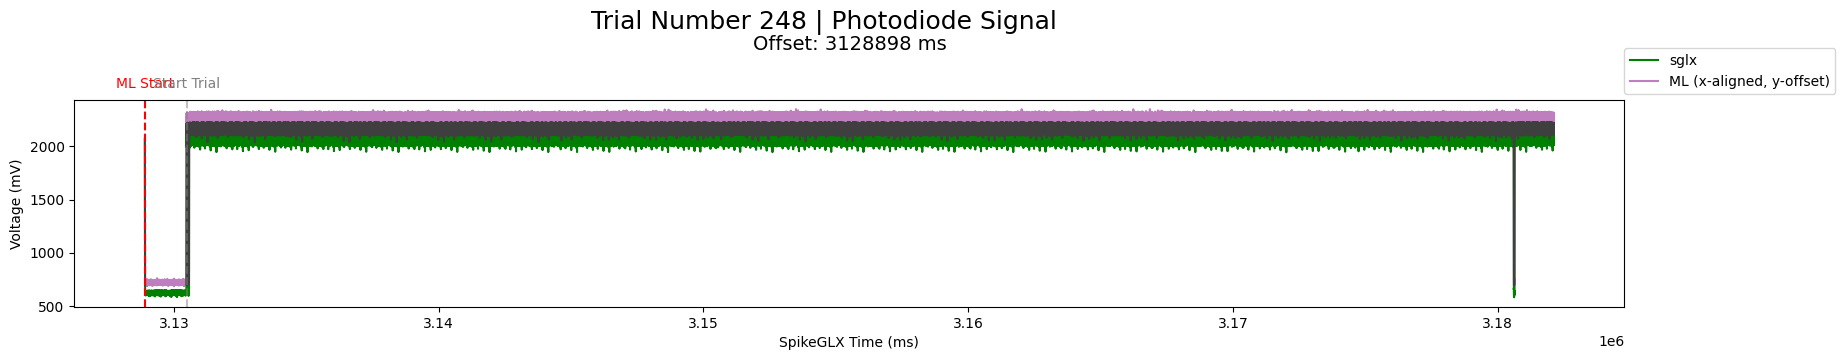

Trial 248:
  ML Cam Start           |  1      
  ML Cam End             |  53226  
  ML Cam Num Frames      |  6388   
  --------------------------------------
  SpikeGLX Trial Start   |  3128897.5
  SpikeGLX Trial End     |  3182127.5
  SpikeGLX Num Frames    |  6388   
  ML-SGLX Correlation: 0.941
  Trial 249 | Epoch start 3182128.0 | Epoch end 3222530.0


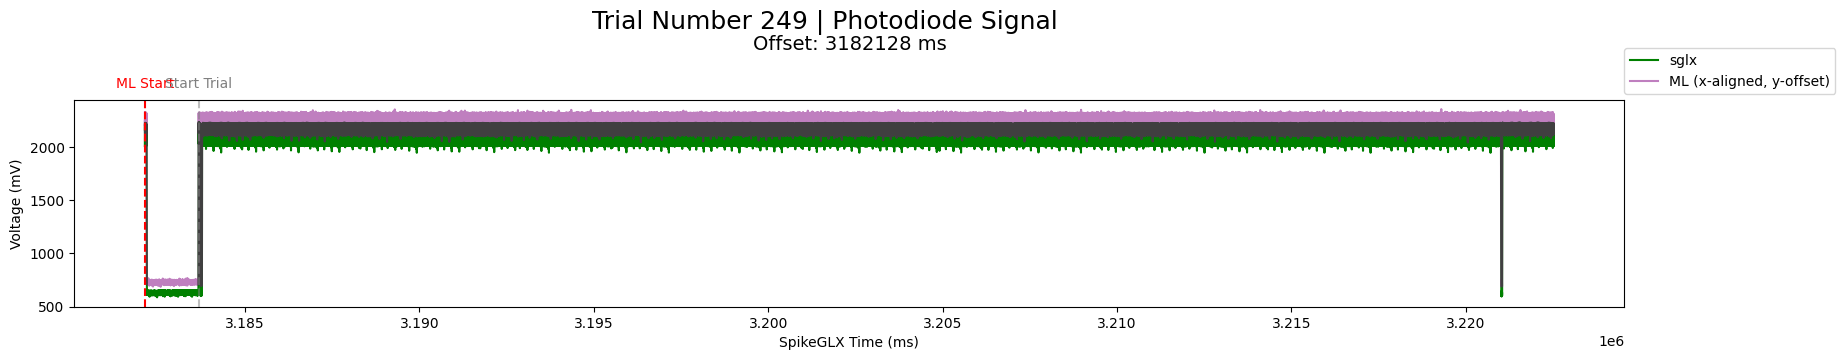

Trial 249:
  ML Cam Start           |  4      
  ML Cam End             |  40396  
  ML Cam Num Frames      |  4848   
  --------------------------------------
  SpikeGLX Trial Start   |  3182128.0
  SpikeGLX Trial End     |  3222530.0
  SpikeGLX Num Frames    |  4848   
  ML-SGLX Correlation: 0.953
Trial 250 | Correlation: 0.994 | SGLX High Time: 2673 | ML High Time: 1536
  Trial 250 | Epoch start 3222530.5 | Epoch end 3232195.5
Trial 251 | Correlation: 0.999 | SGLX High Time: 4375 | ML High Time: 2388
  Trial 251 | Epoch start 3232195.0 | Epoch end 3237354.0
Trial 252 | Correlation: 0.994 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 252 | Epoch start 3237354.5 | Epoch end 3244938.5
Trial 253 | Correlation: 0.998 | SGLX High Time: 4355 | ML High Time: 2377
  Trial 253 | Epoch start 3244939.0 | Epoch end 3251427.0
Trial 254 | Correlation: 0.996 | SGLX High Time: 2738 | ML High Time: 1569
  Trial 254 | Epoch start 3251427.0 | Epoch end 3255721.0
Trial 255 | Correlation: 0.993 | S

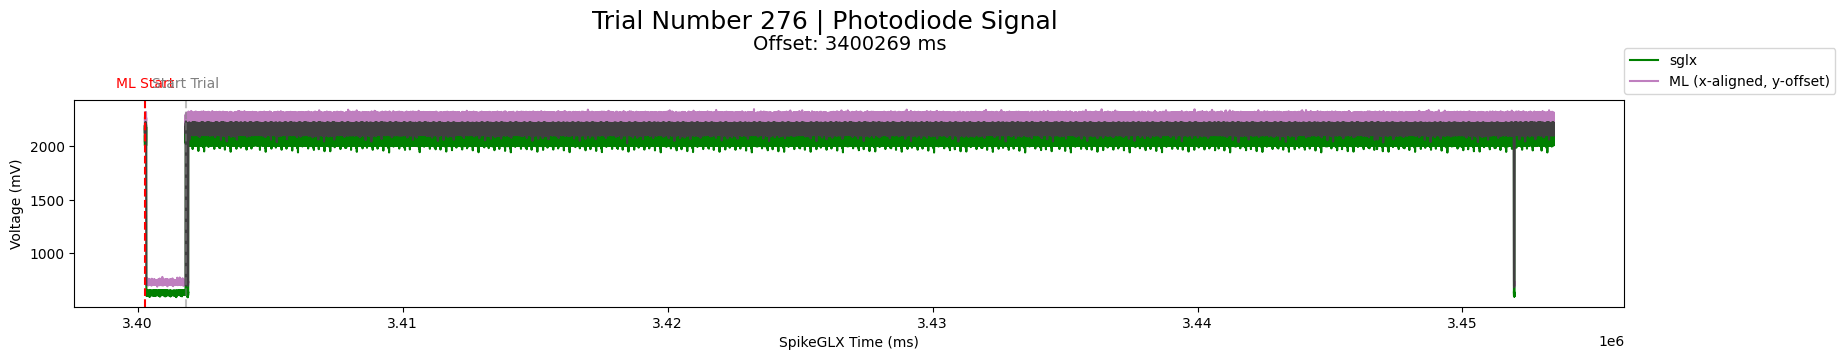

Trial 276:
  ML Cam Start           |  7      
  ML Cam End             |  53182  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  3400269.0
  SpikeGLX Trial End     |  3453453.0
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.939
  Trial 277 | Epoch start 3453453.5 | Epoch end 3506640.5


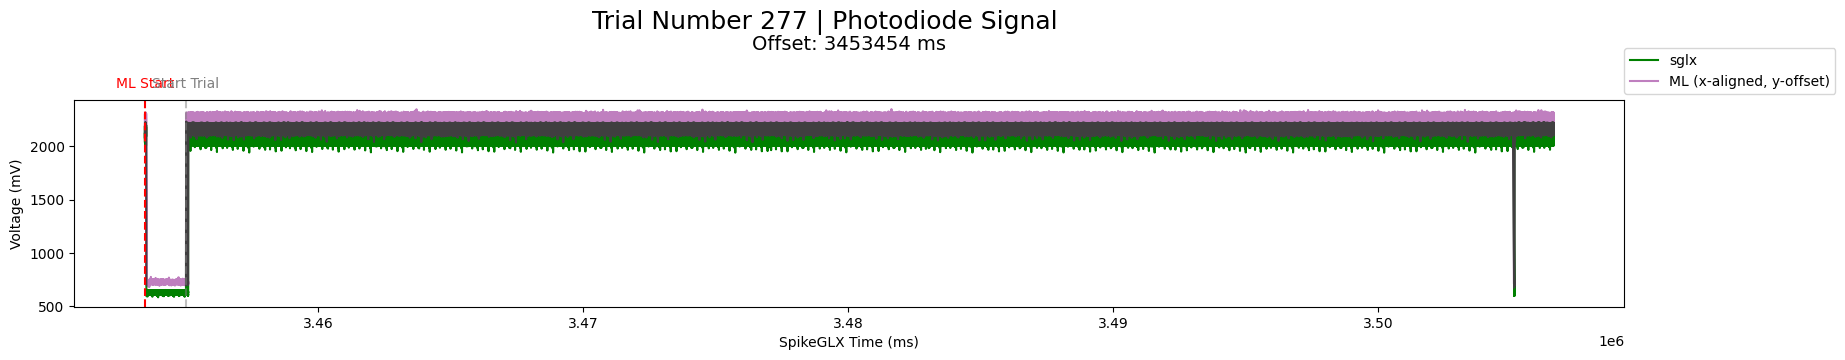

Trial 277:
  ML Cam Start           |  6      
  ML Cam End             |  53181  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  3453453.5
  SpikeGLX Trial End     |  3506640.5
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.94
  Trial 278 | Epoch start 3506641.0 | Epoch end 3559809.0


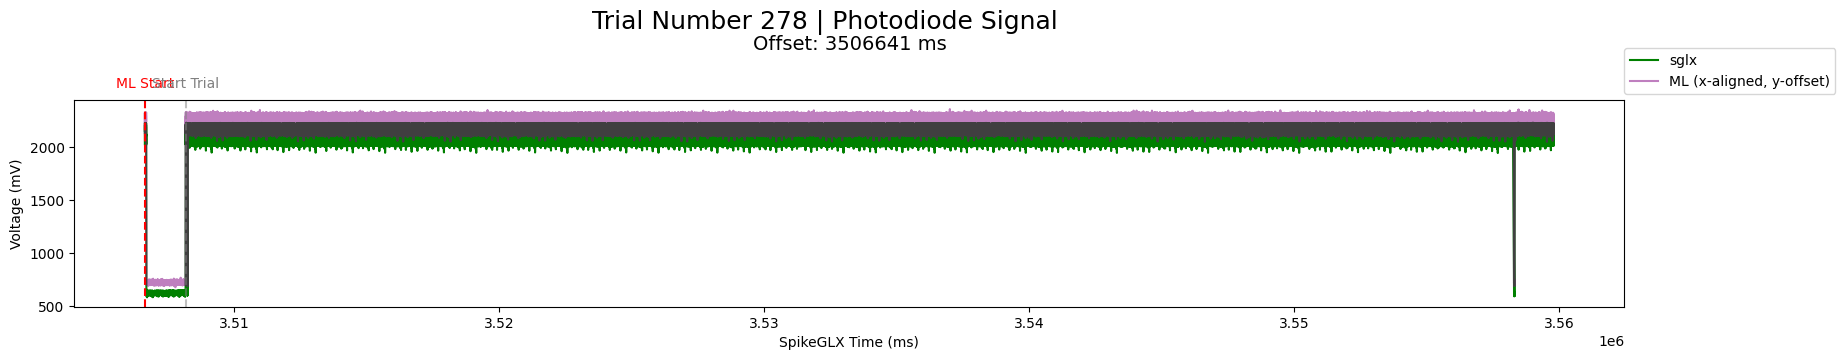

Trial 278:
  ML Cam Start           |  3      
  ML Cam End             |  53161  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  3506641.0
  SpikeGLX Trial End     |  3559809.0
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.939
Trial 279 | Correlation: 0.981 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 279 | Epoch start 3559809.5 | Epoch end 3592390.5
Trial 280 | Correlation: 0.993 | SGLX High Time: 2741 | ML High Time: 1570
  Trial 280 | Epoch start 3592391.0 | Epoch end 3606335.0
Trial 281 | Correlation: 0.995 | SGLX High Time: 2739 | ML High Time: 1569
  Trial 281 | Epoch start 3606335.5 | Epoch end 3614113.5
Trial 282 | Correlation: 0.995 | SGLX High Time: 4375 | ML High Time: 2388
  Trial 282 | Epoch start 3614113.0 | Epoch end 3620690.0
Trial 283 | Correlation: 0.998 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 283 | Epoch start 3620690.5 | Epoch end 3625297.5
Trial 284 | Correlation: 0.995 | S

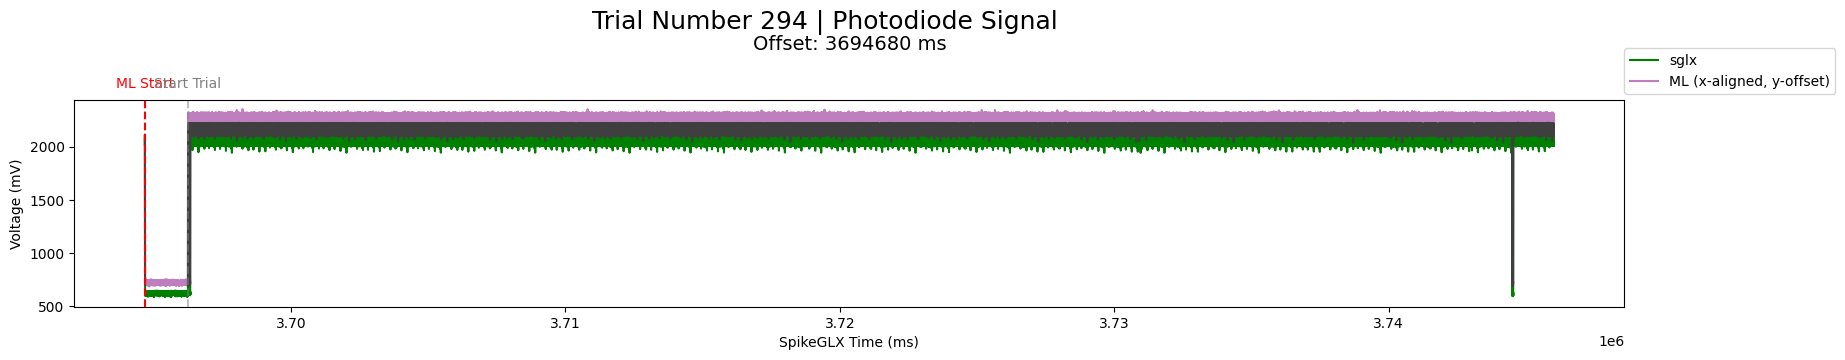

Trial 294:
  ML Cam Start           |  6      
  ML Cam End             |  51331  
  ML Cam Num Frames      |  6160   
  --------------------------------------
  SpikeGLX Trial Start   |  3694680.5
  SpikeGLX Trial End     |  3746020.5
  SpikeGLX Num Frames    |  6160   
  ML-SGLX Correlation: 0.943
Trial 295 | Correlation: 0.992 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 295 | Epoch start 3746021.0 | Epoch end 3759967.0
Trial 296 | Correlation: 0.995 | SGLX High Time: 4398 | ML High Time: 2398
  Trial 296 | Epoch start 3759968.0 | Epoch end 3772110.0
Trial 297 | Correlation: 0.995 | SGLX High Time: 2707 | ML High Time: 1554
  Trial 297 | Epoch start 3772109.5 | Epoch end 3776528.5
Trial 298 | Correlation: 0.994 | SGLX High Time: 2709 | ML High Time: 1555
  Trial 298 | Epoch start 3776528.0 | Epoch end 3787840.0
Trial 299 | Correlation: 0.994 | SGLX High Time: 2740 | ML High Time: 1570
  Trial 299 | Epoch start 3787840.0 | Epoch end 3794472.0
Trial 300 | Correlation: 0.993 | S

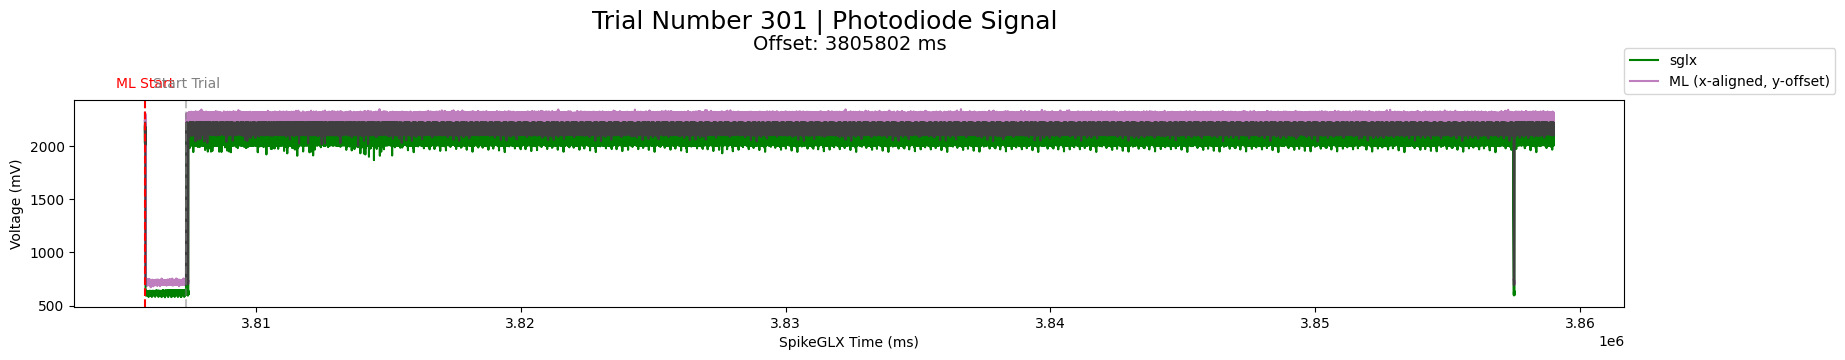

Trial 301:
  ML Cam Start           |  2      
  ML Cam End             |  53210  
  ML Cam Num Frames      |  6386   
  --------------------------------------
  SpikeGLX Trial Start   |  3805802.5
  SpikeGLX Trial End     |  3859018.5
  SpikeGLX Num Frames    |  6386   
  ML-SGLX Correlation: 0.941
  Trial 302 | Epoch start 3859019.5 | Epoch end 3912214.5


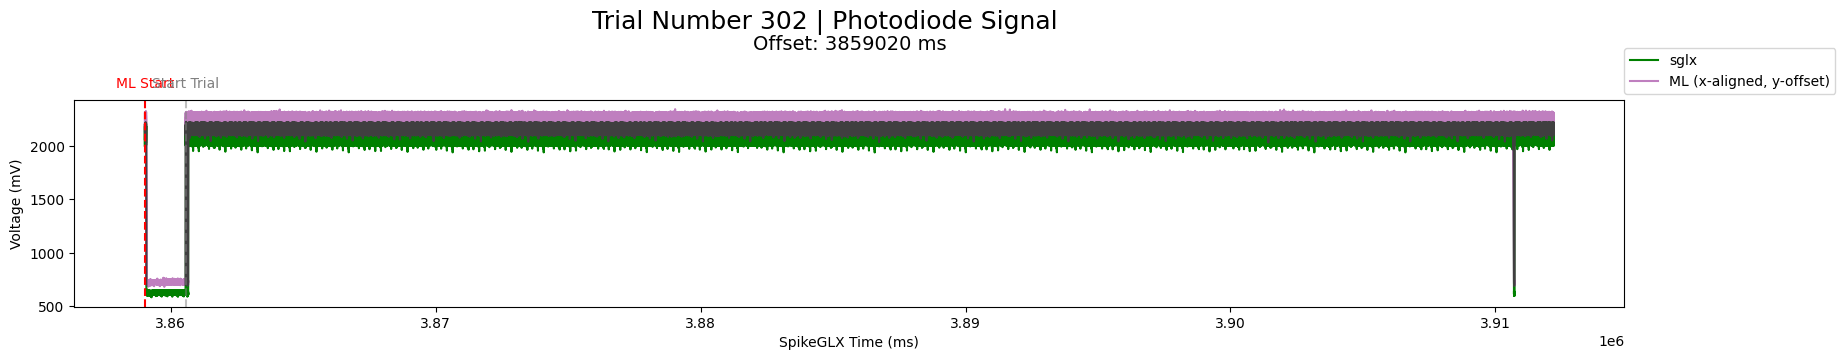

Trial 302:
  ML Cam Start           |  3      
  ML Cam End             |  53194  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  3859019.5
  SpikeGLX Trial End     |  3912214.5
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.938
Trial 303 | Correlation: 0.994 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 303 | Epoch start 3912214.5 | Epoch end 3920845.5
Trial 304 | Correlation: 0.993 | SGLX High Time: 4343 | ML High Time: 2371
  Trial 304 | Epoch start 3920846.0 | Epoch end 3933007.0
Trial 305 | Correlation: 0.993 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 305 | Epoch start 3933007.0 | Epoch end 3944385.0
Trial 306 | Correlation: 0.996 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 306 | Epoch start 3944385.5 | Epoch end 3952101.5
Trial 307 | Correlation: 0.997 | SGLX High Time: 4476 | ML High Time: 2438
  Trial 307 | Epoch start 3952101.5 | Epoch end 3960716.5
Trial 308 | Correlation: 0.998 | S

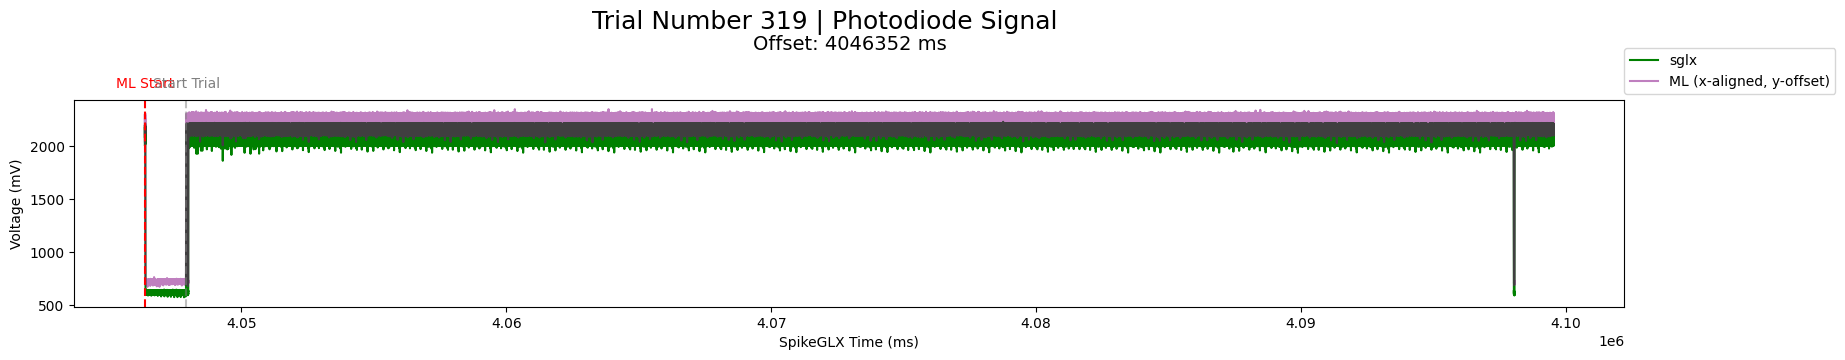

Trial 319:
  ML Cam Start           |  5      
  ML Cam End             |  53205  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  4046352.5
  SpikeGLX Trial End     |  4099558.5
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.939
  Trial 320 | Epoch start 4099558.5 | Epoch end 4152731.5


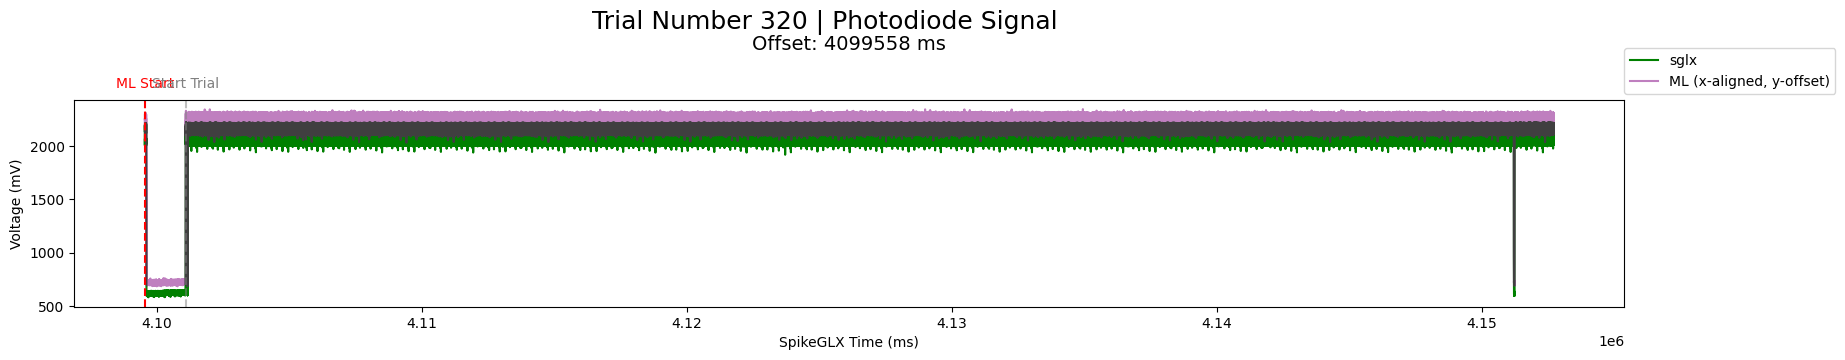

Trial 320:
  ML Cam Start           |  7      
  ML Cam End             |  53166  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  4099558.5
  SpikeGLX Trial End     |  4152731.5
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.939
  Trial 321 | Epoch start 4152732.0 | Epoch end 4205909.0


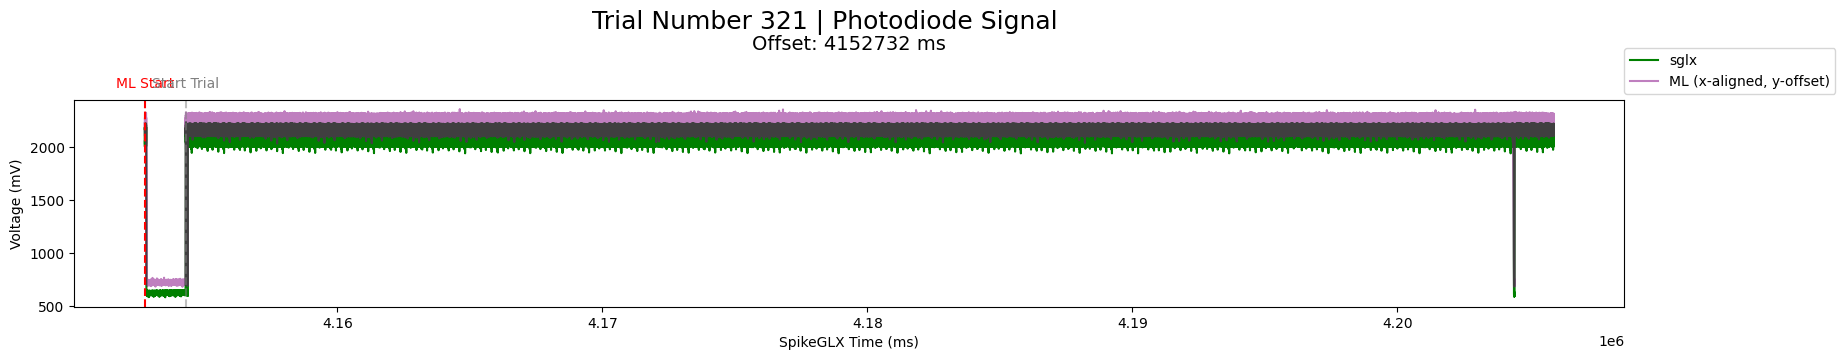

Trial 321:
  ML Cam Start           |  1      
  ML Cam End             |  53176  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  4152732.0
  SpikeGLX Trial End     |  4205909.0
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.939
Trial 322 | Correlation: 0.997 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 322 | Epoch start 4205910.0 | Epoch end 4212307.0
Trial 323 | Correlation: 0.997 | SGLX High Time: 2673 | ML High Time: 1537
  Trial 323 | Epoch start 4212306.5 | Epoch end 4216480.5
Trial 324 | Correlation: 0.999 | SGLX High Time: 2673 | ML High Time: 1536
  Trial 324 | Epoch start 4216481.0 | Epoch end 4220504.0
Trial 325 | Correlation: 0.997 | SGLX High Time: 2673 | ML High Time: 1537
  Trial 325 | Epoch start 4220503.5 | Epoch end 4228282.5
Trial 326 | Correlation: 0.995 | SGLX High Time: 4397 | ML High Time: 2398
  Trial 326 | Epoch start 4228283.0 | Epoch end 4235943.0
Trial 327 | Correlation: 0.998 | S

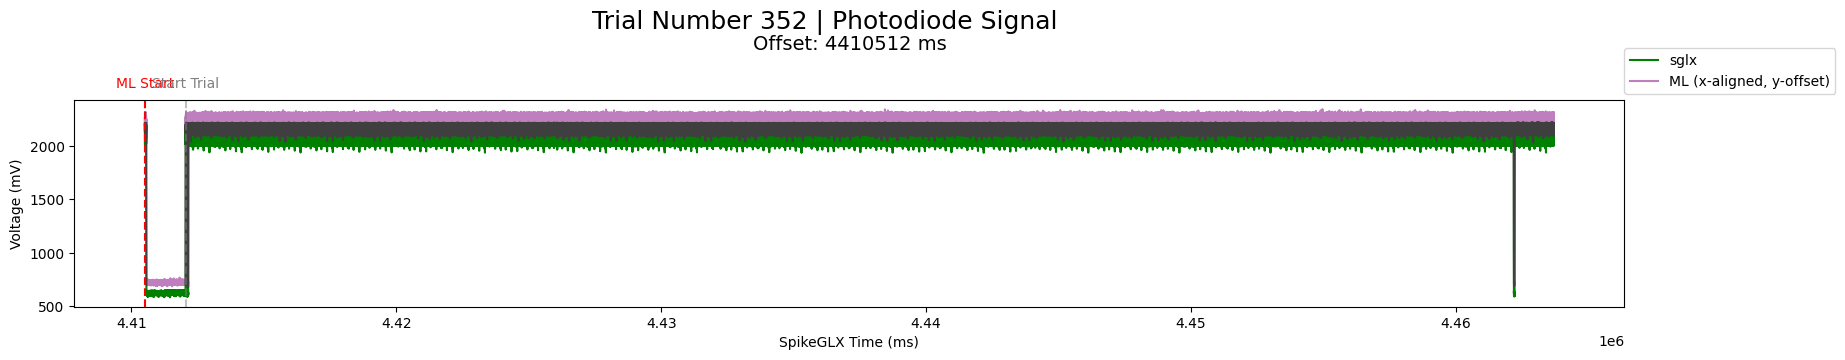

Trial 352:
  ML Cam Start           |  7      
  ML Cam End             |  53182  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  4410512.0
  SpikeGLX Trial End     |  4463700.0
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.937
  Trial 353 | Epoch start 4463700.5 | Epoch end 4516874.5


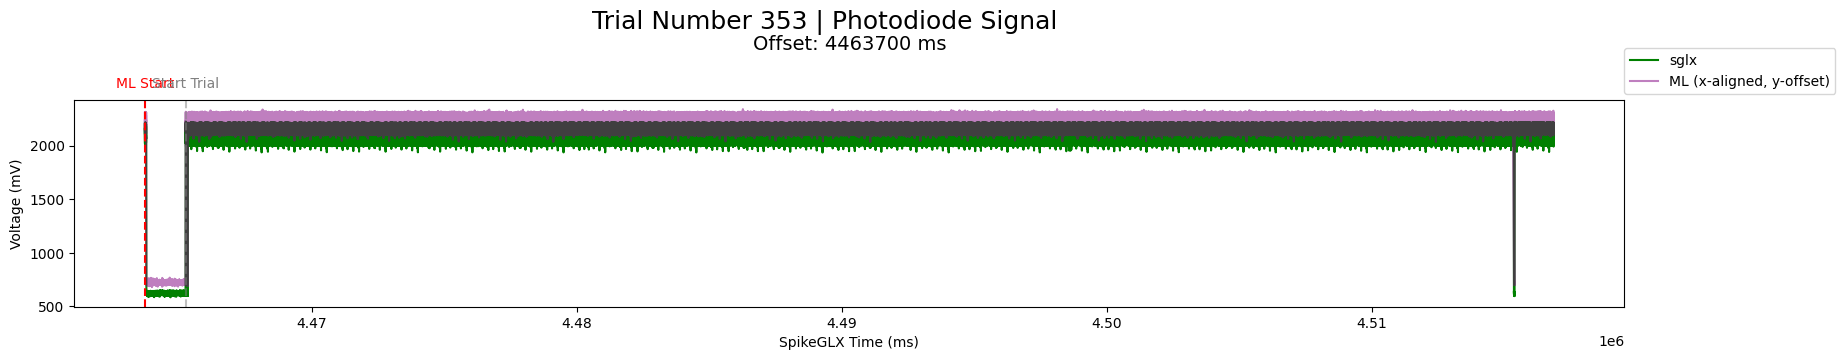

Trial 353:
  ML Cam Start           |  3      
  ML Cam End             |  53170  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  4463700.5
  SpikeGLX Trial End     |  4516874.5
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.937
Trial 354 | Correlation: 0.993 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 354 | Epoch start 4516875.5 | Epoch end 4528965.5
Trial 355 | Correlation: 0.994 | SGLX High Time: 2772 | ML High Time: 1587
  Trial 355 | Epoch start 4528964.5 | Epoch end 4540304.5
Trial 356 | Correlation: 0.994 | SGLX High Time: 2740 | ML High Time: 1570
  Trial 356 | Epoch start 4540304.5 | Epoch end 4547966.5
Trial 357 | Correlation: 0.994 | SGLX High Time: 4342 | ML High Time: 2371
  Trial 357 | Epoch start 4547966.5 | Epoch end 4556196.5
Trial 358 | Correlation: 0.998 | SGLX High Time: 4410 | ML High Time: 2405
  Trial 358 | Epoch start 4556196.5 | Epoch end 4562574.5
Trial 359 | Correlation: 0.993 | S

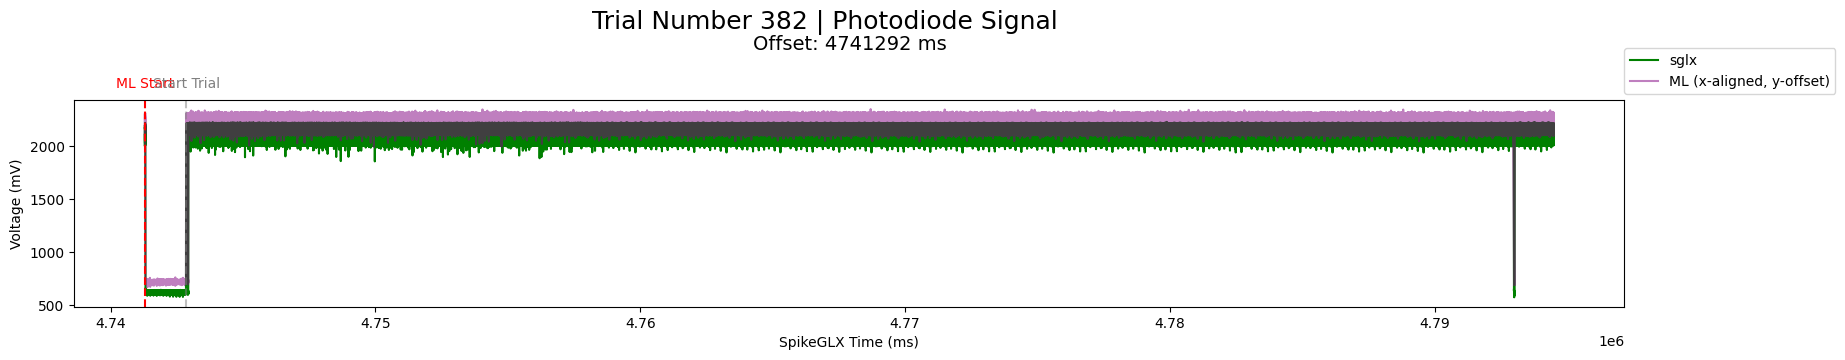

Trial 382:
  ML Cam Start           |  6      
  ML Cam End             |  53206  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  4741292.0
  SpikeGLX Trial End     |  4794504.0
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.938
Trial 383 | Correlation: 0.993 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 383 | Epoch start 4794504.5 | Epoch end 4798594.5
  Trial 384 | Epoch start 4798594.0 | Epoch end 4851778.0


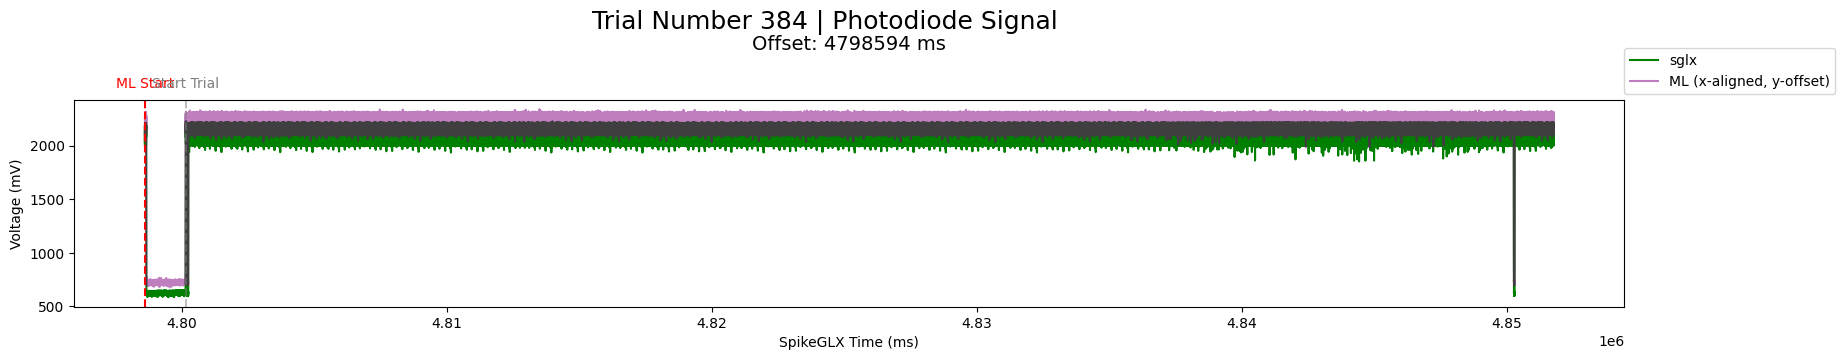

Trial 384:
  ML Cam Start           |  4      
  ML Cam End             |  53179  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  4798594.0
  SpikeGLX Trial End     |  4851778.0
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.938
  Trial 385 | Epoch start 4851779.0 | Epoch end 4904984.0


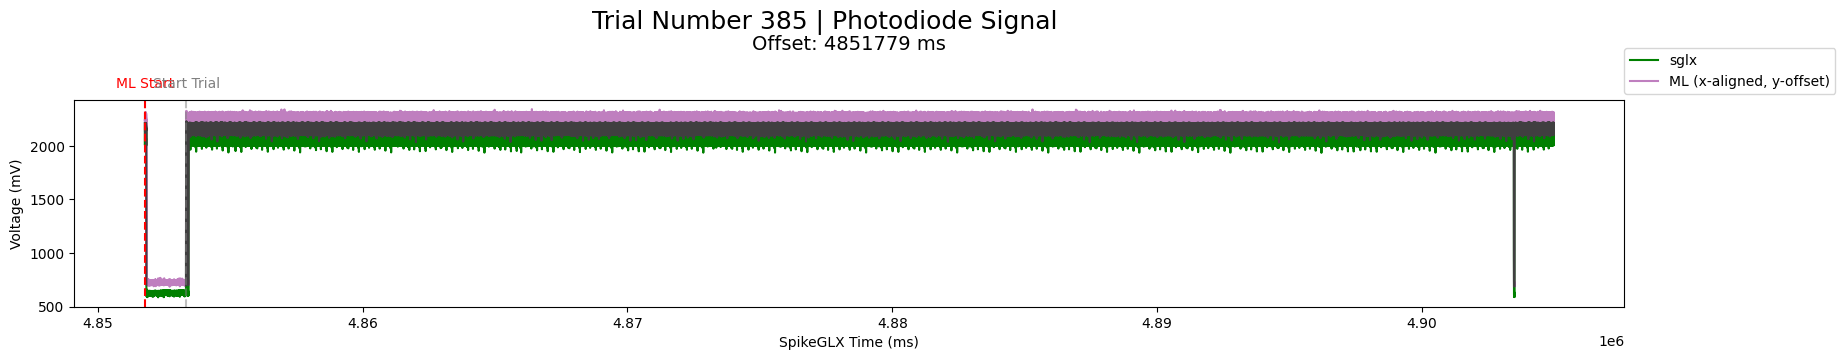

Trial 385:
  ML Cam Start           |  3      
  ML Cam End             |  53203  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  4851779.0
  SpikeGLX Trial End     |  4904984.0
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.94
  Trial 386 | Epoch start 4904984.5 | Epoch end 4958172.5


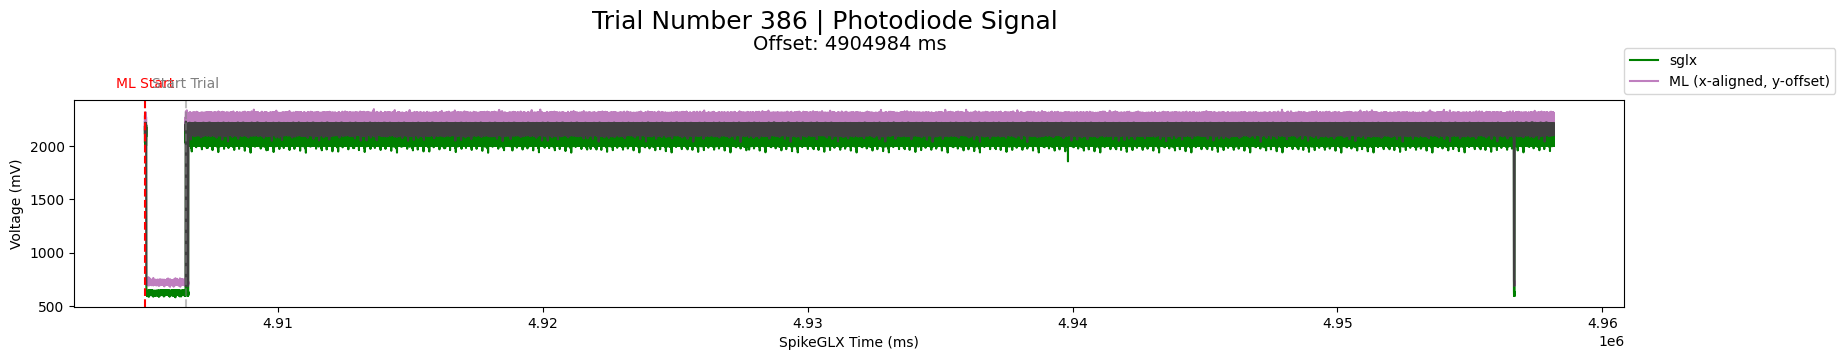

Trial 386:
  ML Cam Start           |  6      
  ML Cam End             |  53181  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  4904984.5
  SpikeGLX Trial End     |  4958172.5
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.938
  Trial 387 | Epoch start 4958172.5 | Epoch end 5013115.5


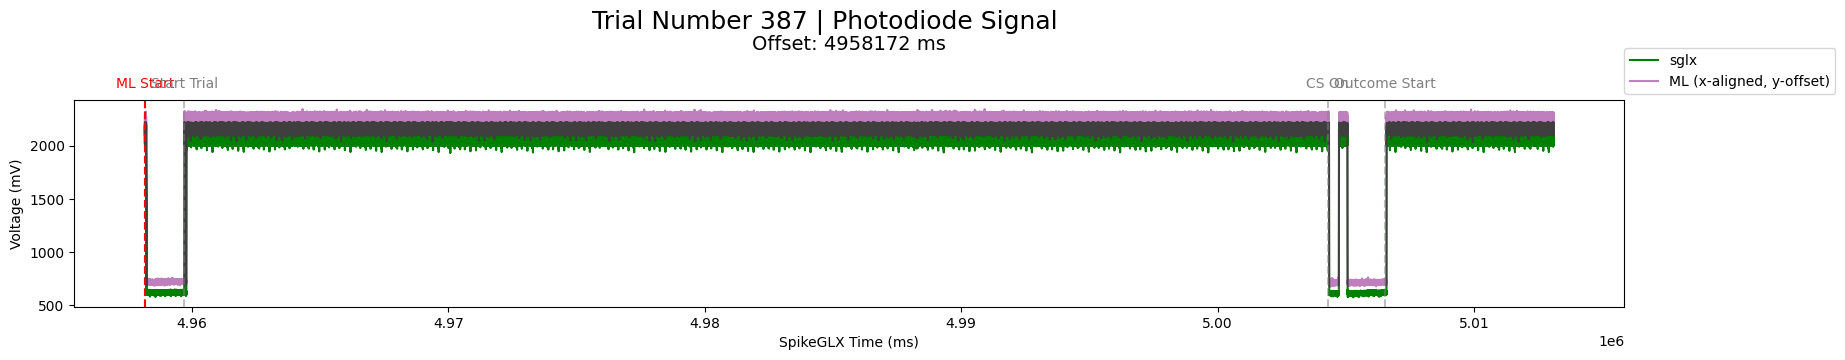

Trial 387:
  ML Cam Start           |  2      
  ML Cam End             |  54935  
  ML Cam Num Frames      |  6593   
  --------------------------------------
  SpikeGLX Trial Start   |  4958172.5
  SpikeGLX Trial End     |  5013115.5
  SpikeGLX Num Frames    |  6593   
  ML-SGLX Correlation: 0.969
Trial 388 | Correlation: 0.996 | SGLX High Time: 2742 | ML High Time: 1570
  Trial 388 | Epoch start 5013116.5 | Epoch end 5017389.5
Trial 389 | Correlation: 0.997 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 389 | Epoch start 5017390.0 | Epoch end 5023973.0
Trial 390 | Correlation: 0.996 | SGLX High Time: 2707 | ML High Time: 1554
  Trial 390 | Epoch start 5023972.5 | Epoch end 5031927.5
Trial 391 | Correlation: 0.997 | SGLX High Time: 4396 | ML High Time: 2398
  Trial 391 | Epoch start 5031927.5 | Epoch end 5040379.5
Trial 392 | Correlation: 0.995 | SGLX High Time: 4314 | ML High Time: 2356
  Trial 392 | Epoch start 5040380.5 | Epoch end 5048823.5
Trial 393 | Correlation: 0.995 | S

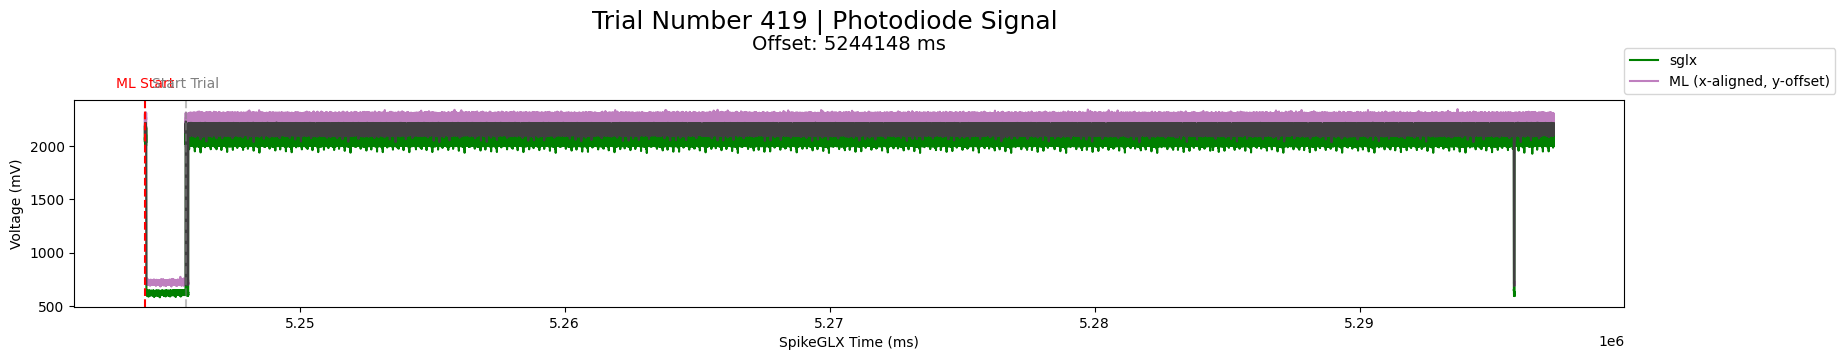

Trial 419:
  ML Cam Start           |  5      
  ML Cam End             |  53188  
  ML Cam Num Frames      |  6383   
  --------------------------------------
  SpikeGLX Trial Start   |  5244148.0
  SpikeGLX Trial End     |  5297338.0
  SpikeGLX Num Frames    |  6383   
  ML-SGLX Correlation: 0.94
Trial 420 | Correlation: 0.981 | SGLX High Time: 2673 | ML High Time: 1536
  Trial 420 | Epoch start 5297338.5 | Epoch end 5333079.5
Trial 421 | Correlation: 0.988 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 421 | Epoch start 5333080.0 | Epoch end 5339876.0
Trial 422 | Correlation: 0.986 | SGLX High Time: 2672 | ML High Time: 1536
  Trial 422 | Epoch start 5339876.0 | Epoch end 5349891.0
  Trial 423 | Epoch start 5349891.0 | Epoch end 5403078.0


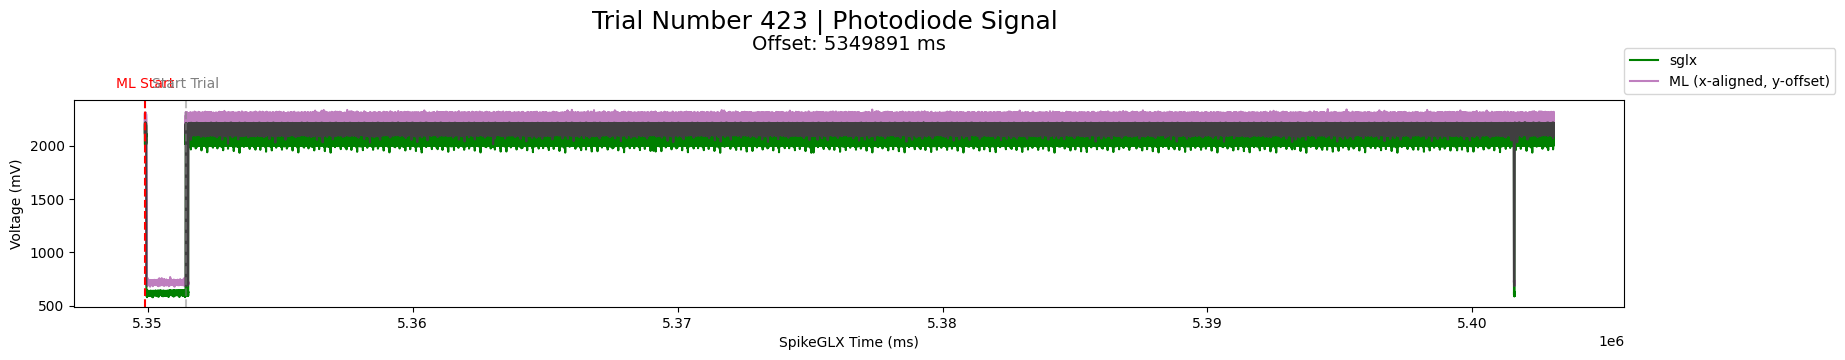

Trial 423:
  ML Cam Start           |  4      
  ML Cam End             |  53179  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  5349891.0
  SpikeGLX Trial End     |  5403078.0
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.94
Trial 424 | Correlation: 0.983 | SGLX High Time: 2673 | ML High Time: 1536
  Trial 424 | Epoch start 5403078.5 | Epoch end 5417337.5
Trial 425 | Correlation: 0.998 | SGLX High Time: 2673 | ML High Time: 1537
  Trial 425 | Epoch start 5417337.0 | Epoch end 5423450.0
Trial 426 | Correlation: 0.998 | SGLX High Time: 2710 | ML High Time: 1554
  Trial 426 | Epoch start 5423451.0 | Epoch end 5429050.0
Trial 427 | Correlation: 0.997 | SGLX High Time: 2737 | ML High Time: 1569
  Trial 427 | Epoch start 5429049.5 | Epoch end 5434256.5
Trial 428 | Correlation: 0.995 | SGLX High Time: 2674 | ML High Time: 1537
  Trial 428 | Epoch start 5434256.5 | Epoch end 5445361.5
Trial 429 | Correlation: 0.994 | SG

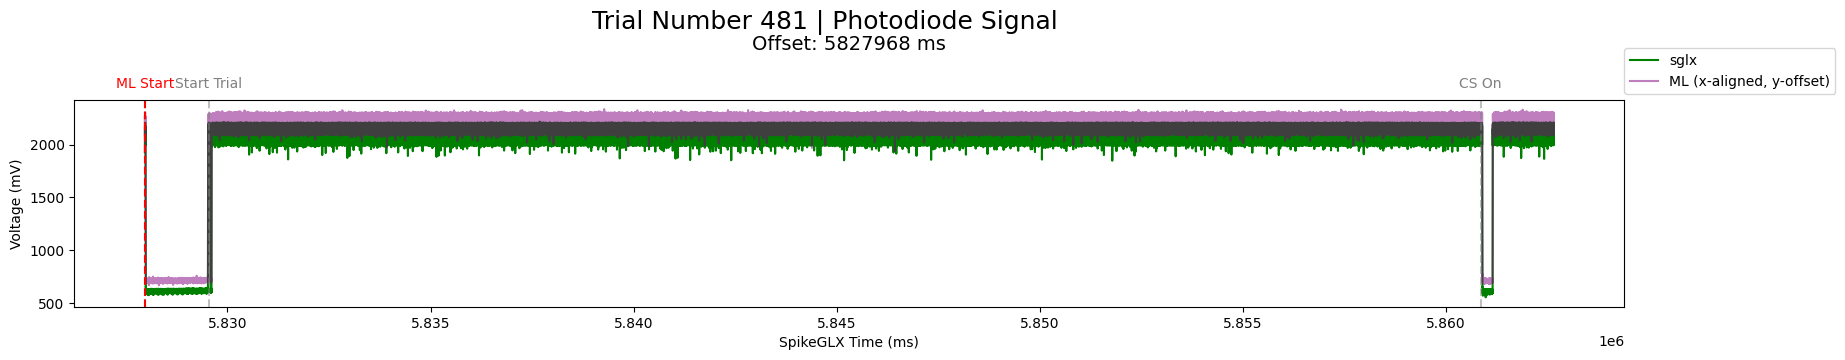

Trial 481:
  ML Cam Start           |  7      
  ML Cam End             |  34682  
  ML Cam Num Frames      |  4162   
  --------------------------------------
  SpikeGLX Trial Start   |  5827967.5
  SpikeGLX Trial End     |  5862654.5
  SpikeGLX Num Frames    |  4162   
  ML-SGLX Correlation: 0.966
  Trial 482 | Epoch start 5862654.5 | Epoch end 5915818.5


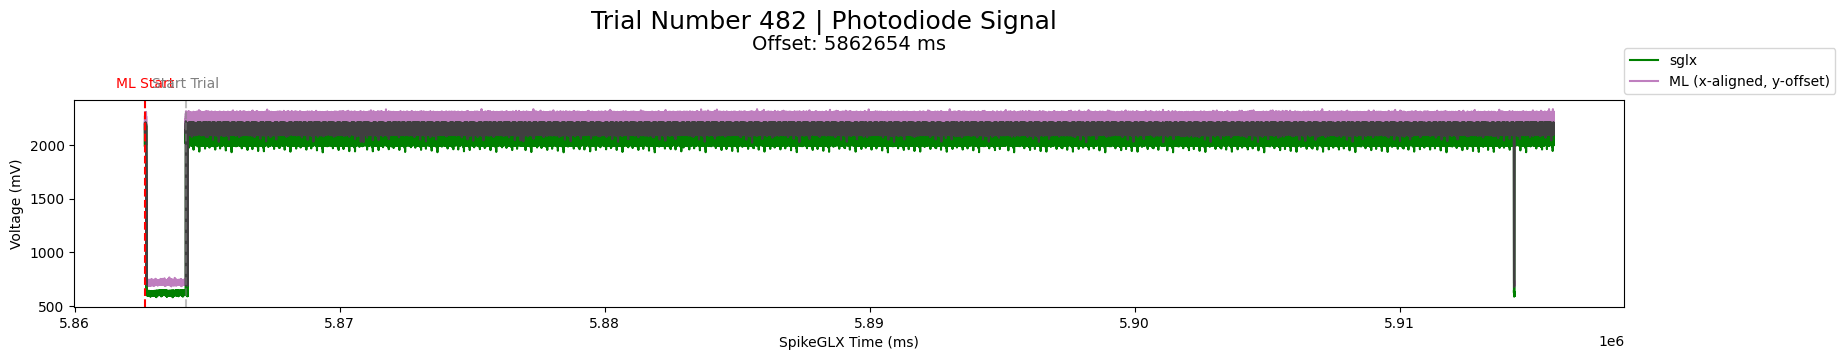

Trial 482:
  ML Cam Start           |  4      
  ML Cam End             |  53162  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  5862654.5
  SpikeGLX Trial End     |  5915818.5
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.936
  Trial 483 | Epoch start 5915819.5 | Epoch end 5969004.5


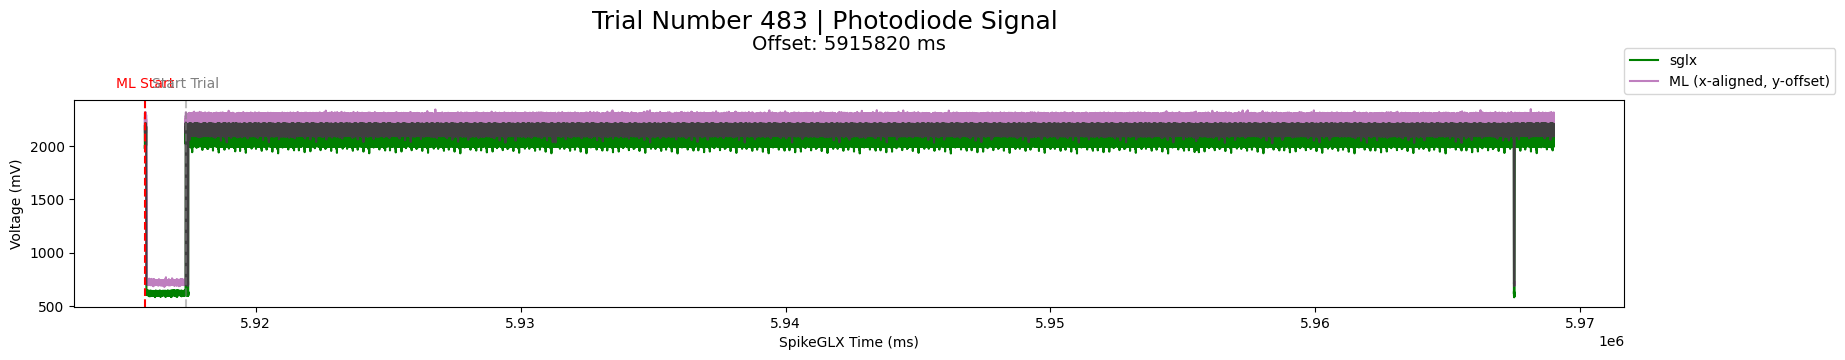

Trial 483:
  ML Cam Start           |  6      
  ML Cam End             |  53181  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  5915819.5
  SpikeGLX Trial End     |  5969004.5
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.937
Trial 484 | Correlation: 0.992 | SGLX High Time: 2673 | ML High Time: 1536
  Trial 484 | Epoch start 5969005.0 | Epoch end 5972745.0
Trial 485 | Correlation: 0.998 | SGLX High Time: 2672 | ML High Time: 1536
  Trial 485 | Epoch start 5972745.0 | Epoch end 5977653.0
  Trial 486 | Epoch start 5977653.0 | Epoch end 6030815.0


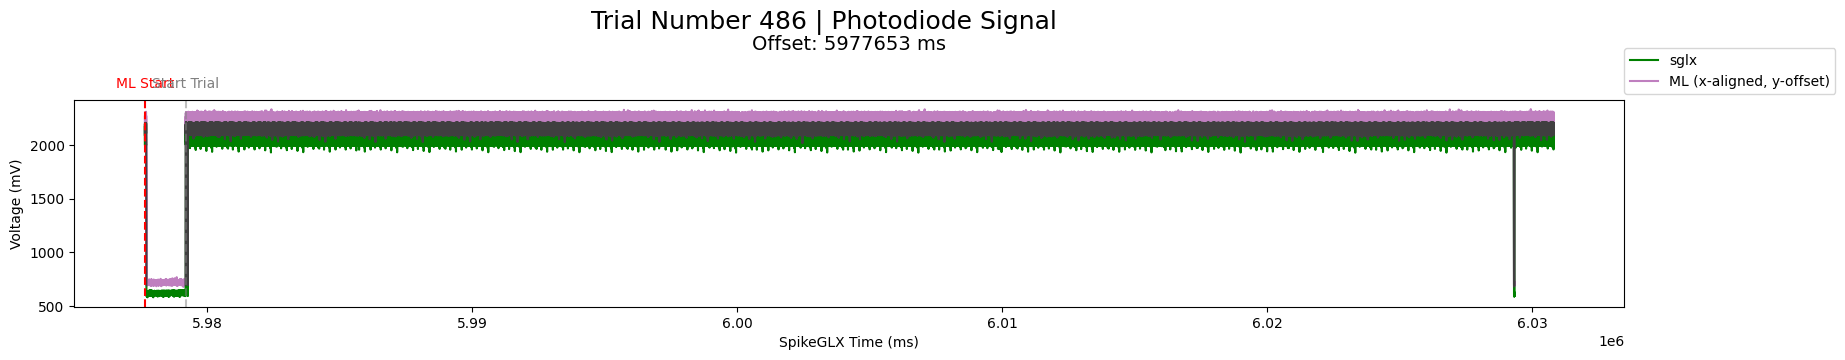

Trial 486:
  ML Cam Start           |  7      
  ML Cam End             |  53157  
  ML Cam Num Frames      |  6379   
  --------------------------------------
  SpikeGLX Trial Start   |  5977653.0
  SpikeGLX Trial End     |  6030815.0
  SpikeGLX Num Frames    |  6379   
  ML-SGLX Correlation: 0.936
Trial 487 | Correlation: 0.988 | SGLX High Time: 2673 | ML High Time: 1536
  Trial 487 | Epoch start 6030815.5 | Epoch end 6051513.5
Trial 488 | Correlation: 0.996 | SGLX High Time: 2739 | ML High Time: 1569
  Trial 488 | Epoch start 6051514.0 | Epoch end 6059309.0
Trial 489 | Correlation: 0.997 | SGLX High Time: 4518 | ML High Time: 2460
  Trial 489 | Epoch start 6059308.0 | Epoch end 6067866.0
Trial 490 | Correlation: 0.995 | SGLX High Time: 4356 | ML High Time: 2377
  Trial 490 | Epoch start 6067867.0 | Epoch end 6079820.0
Trial 491 | Correlation: 0.981 | SGLX High Time: 2739 | ML High Time: 1570
  Trial 491 | Epoch start 6079819.5 | Epoch end 6094192.5
Trial 492 | Correlation: 0.999 | S

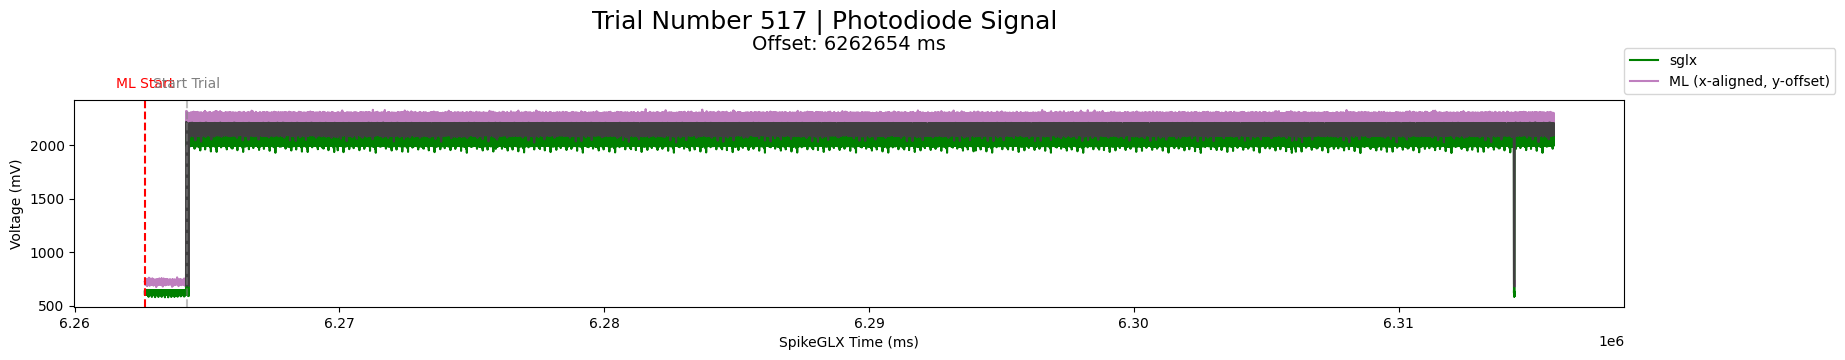

Trial 517:
  ML Cam Start           |  8      
  ML Cam End             |  53208  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  6262654.5
  SpikeGLX Trial End     |  6315868.5
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.942
  Trial 518 | Epoch start 6315869.0 | Epoch end 6369052.0


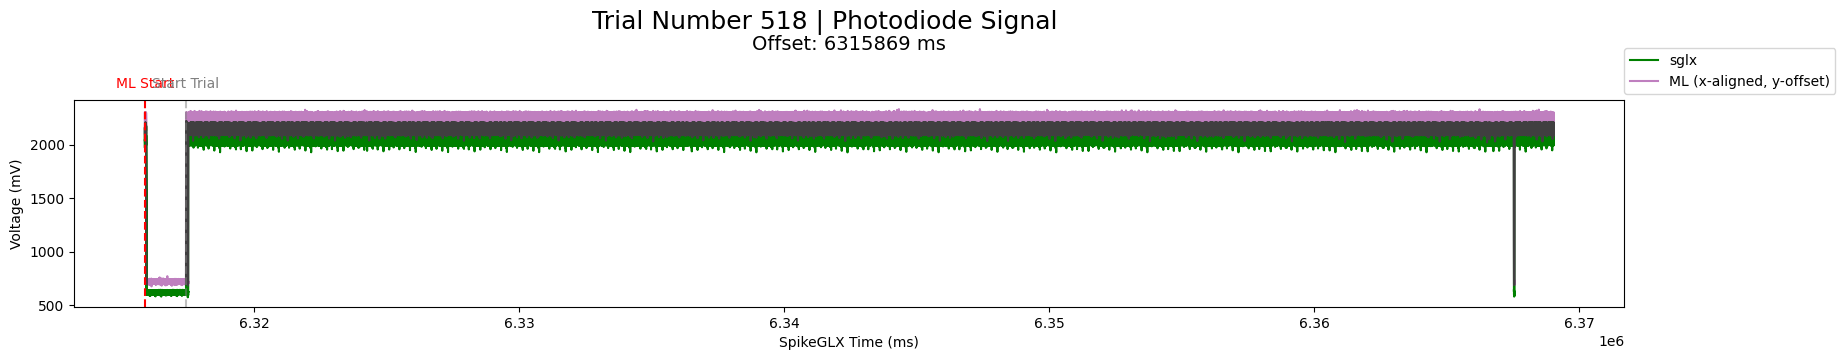

Trial 518:
  ML Cam Start           |  2      
  ML Cam End             |  53177  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  6315869.0
  SpikeGLX Trial End     |  6369052.0
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.939
  Trial 519 | Epoch start 6369052.0 | Epoch end 6422263.0


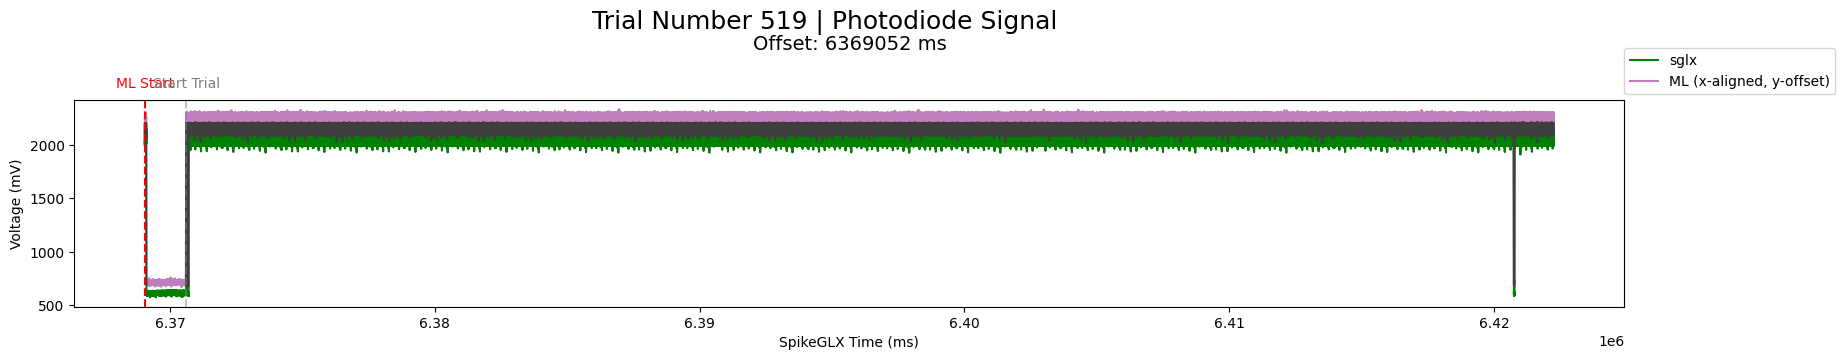

Trial 519:
  ML Cam Start           |  2      
  ML Cam End             |  53202  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  6369052.0
  SpikeGLX Trial End     |  6422263.0
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.937
Trial 520 | Correlation: 0.992 | SGLX High Time: 2674 | ML High Time: 1536
  Trial 520 | Epoch start 6422264.0 | Epoch end 6426387.0
  Trial 521 | Epoch start 6426387.5 | Epoch end 6479570.5


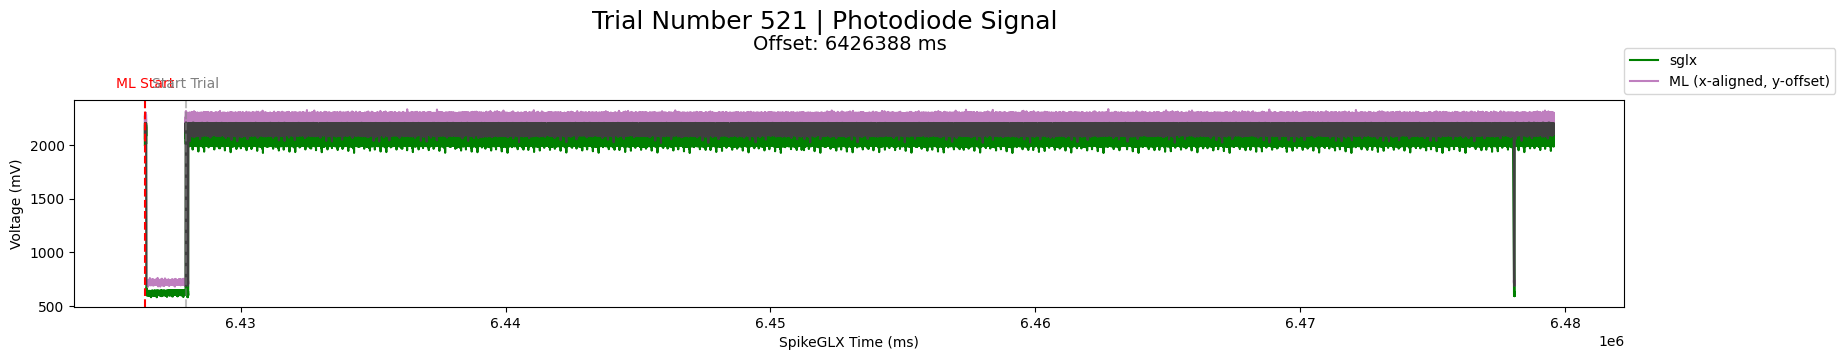

Trial 521:
  ML Cam Start           |  2      
  ML Cam End             |  53177  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  6426387.5
  SpikeGLX Trial End     |  6479570.5
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.937
  Trial 522 | Epoch start 6479571.0 | Epoch end 6537910.0


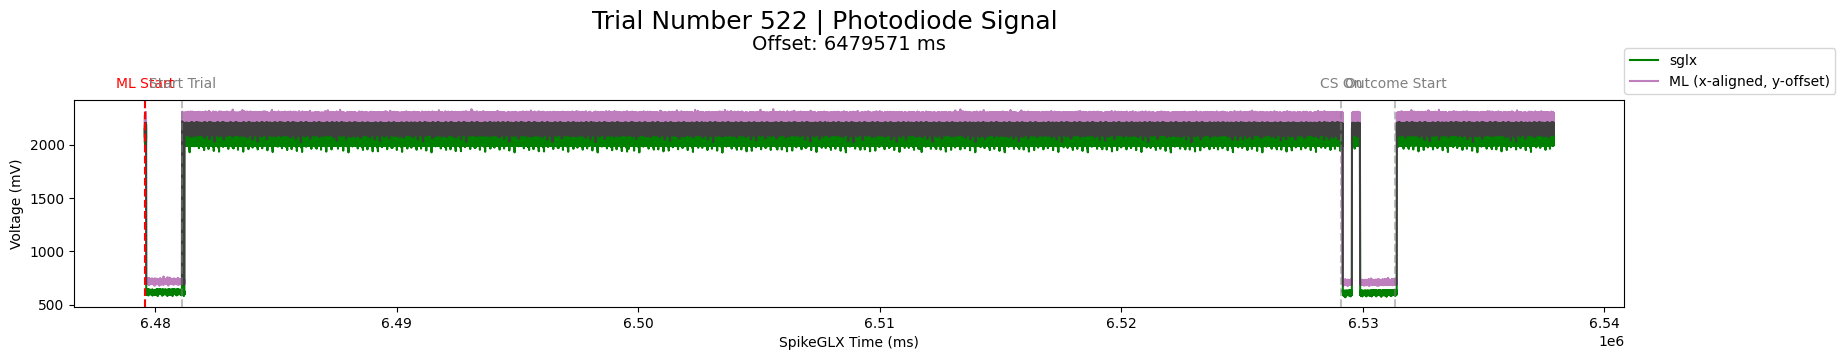

Trial 522:
  ML Cam Start           |  2      
  ML Cam End             |  58335  
  ML Cam Num Frames      |  7001   
  --------------------------------------
  SpikeGLX Trial Start   |  6479571.0
  SpikeGLX Trial End     |  6537910.0
  SpikeGLX Num Frames    |  7001   
  ML-SGLX Correlation: 0.97
Trial 523 | Correlation: 0.991 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 523 | Epoch start 6537910.5 | Epoch end 6551808.5
Trial 524 | Correlation: 0.998 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 524 | Epoch start 6551808.5 | Epoch end 6557493.5
Trial 525 | Correlation: 0.995 | SGLX High Time: 2708 | ML High Time: 1554
  Trial 525 | Epoch start 6557493.5 | Epoch end 6565094.5
Trial 526 | Correlation: 0.995 | SGLX High Time: 4436 | ML High Time: 2418
  Trial 526 | Epoch start 6565094.5 | Epoch end 6572556.5
Trial 527 | Correlation: 0.993 | SGLX High Time: 2709 | ML High Time: 1554
  Trial 527 | Epoch start 6572557.0 | Epoch end 6583730.0
Trial 528 | Correlation: 0.997 | SG

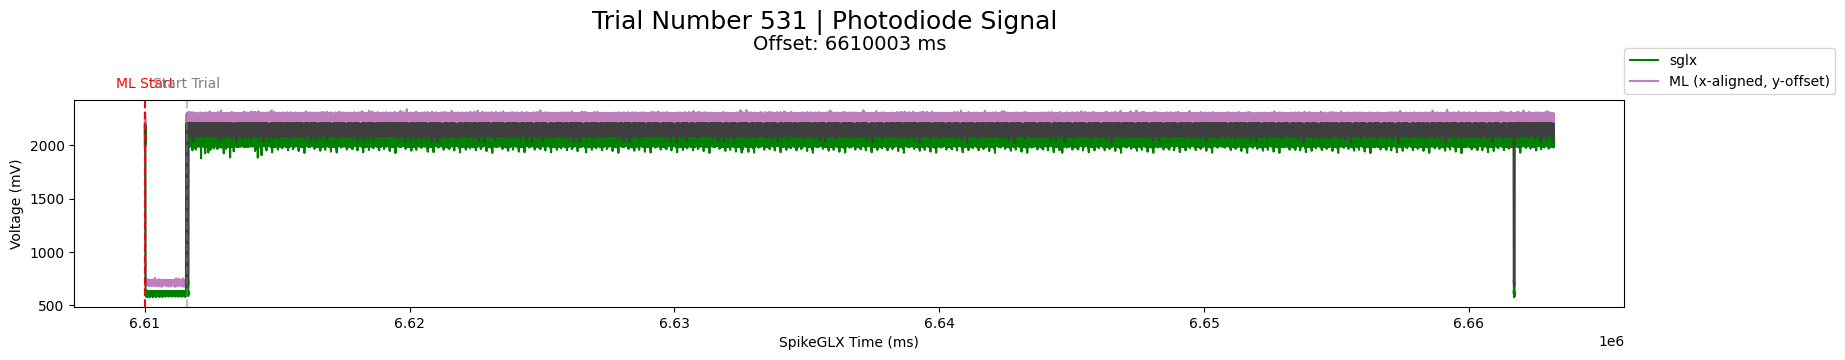

Trial 531:
  ML Cam Start           |  4      
  ML Cam End             |  53204  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  6610003.0
  SpikeGLX Trial End     |  6663215.0
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.938
Trial 532 | Correlation: 0.995 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 532 | Epoch start 6663215.5 | Epoch end 6667455.5
Trial 533 | Correlation: 0.995 | SGLX High Time: 2710 | ML High Time: 1555
  Trial 533 | Epoch start 6667455.5 | Epoch end 6675049.5
Trial 534 | Correlation: 0.994 | SGLX High Time: 4231 | ML High Time: 2316
  Trial 534 | Epoch start 6675049.0 | Epoch end 6687338.0
Trial 535 | Correlation: 0.997 | SGLX High Time: 2741 | ML High Time: 1570
  Trial 535 | Epoch start 6687338.5 | Epoch end 6693515.5
Trial 536 | Correlation: 0.995 | SGLX High Time: 2709 | ML High Time: 1555
  Trial 536 | Epoch start 6693515.0 | Epoch end 6701550.0
Trial 537 | Correlation: 0.995 | S

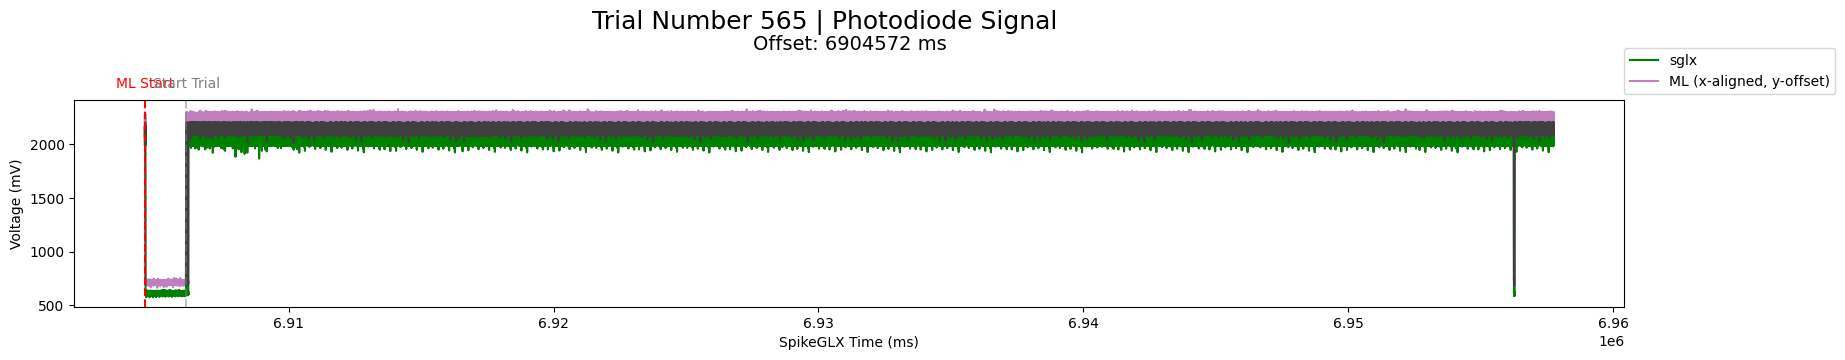

Trial 565:
  ML Cam Start           |  5      
  ML Cam End             |  53188  
  ML Cam Num Frames      |  6383   
  --------------------------------------
  SpikeGLX Trial Start   |  6904571.5
  SpikeGLX Trial End     |  6957768.5
  SpikeGLX Num Frames    |  6383   
  ML-SGLX Correlation: 0.941
Trial 566 | Correlation: 0.996 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 566 | Epoch start 6957769.0 | Epoch end 6961342.0
  Trial 567 | Epoch start 6961342.0 | Epoch end 7014551.0


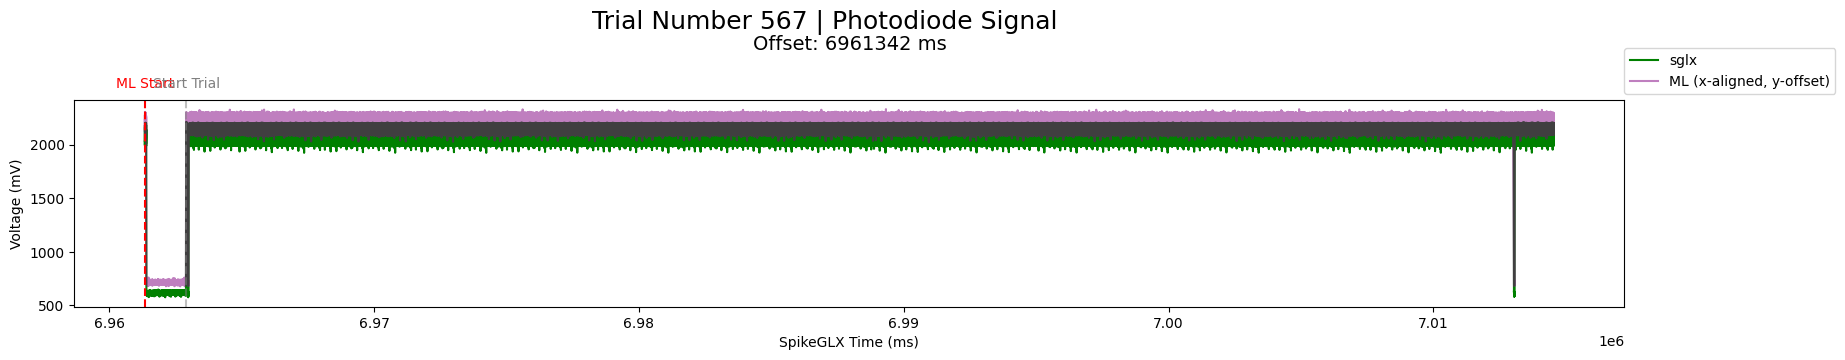

Trial 567:
  ML Cam Start           |  2      
  ML Cam End             |  53202  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  6961342.0
  SpikeGLX Trial End     |  7014551.0
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.937
Trial 568 | Correlation: 0.995 | SGLX High Time: 2675 | ML High Time: 1537
  Trial 568 | Epoch start 7014551.5 | Epoch end 7018691.5
  Trial 569 | Epoch start 7018692.0 | Epoch end 7071878.0


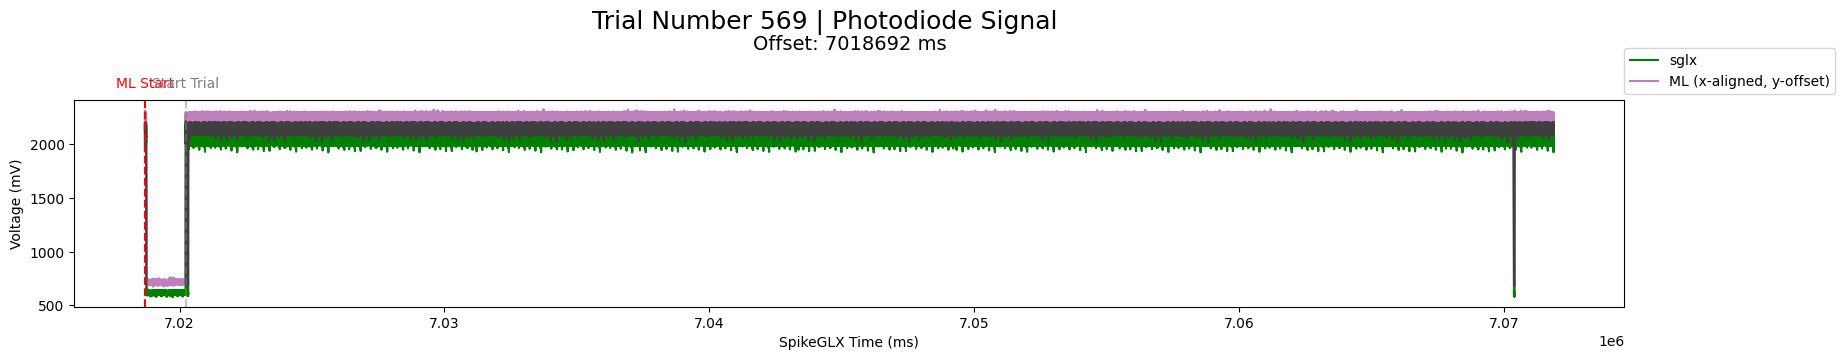

Trial 569:
  ML Cam Start           |  3      
  ML Cam End             |  53178  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  7018692.0
  SpikeGLX Trial End     |  7071878.0
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.94
  Trial 570 | Epoch start 7071879.0 | Epoch end 7125067.0


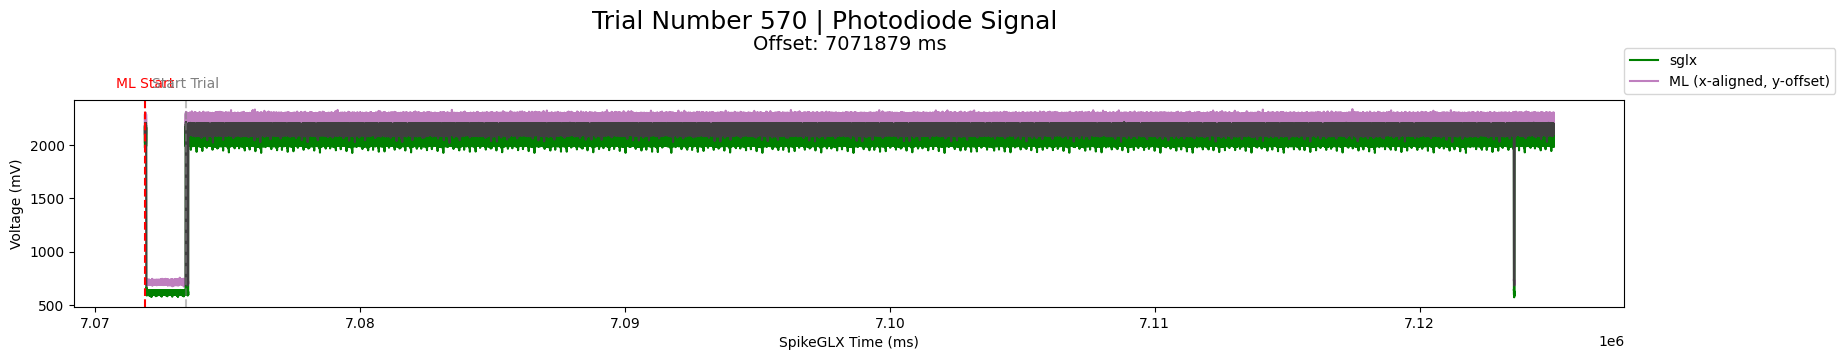

Trial 570:
  ML Cam Start           |  8      
  ML Cam End             |  53183  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  7071879.0
  SpikeGLX Trial End     |  7125067.0
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.939
  Trial 571 | Epoch start 7125067.0 | Epoch end 7178240.0


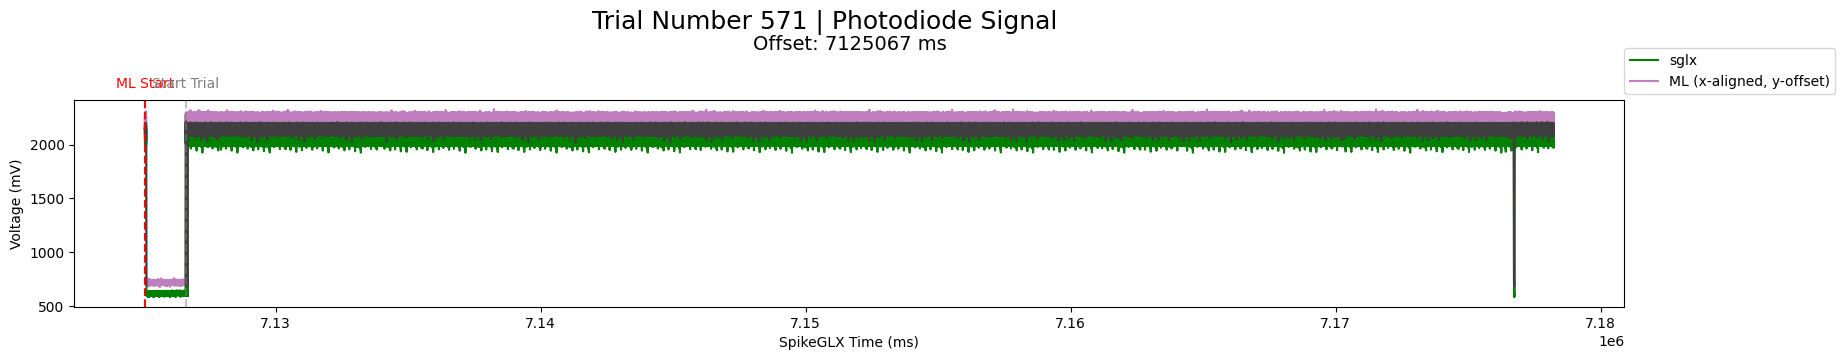

Trial 571:
  ML Cam Start           |  4      
  ML Cam End             |  53170  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  7125067.0
  SpikeGLX Trial End     |  7178240.0
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.938
Trial 572 | Correlation: 0.987 | SGLX High Time: 2673 | ML High Time: 1536
  Trial 572 | Epoch start 7178240.5 | Epoch end 7195388.5
Trial 573 | Correlation: 0.995 | SGLX High Time: 2738 | ML High Time: 1569
  Trial 573 | Epoch start 7195388.5 | Epoch end 7203402.5
Trial 574 | Correlation: 0.999 | SGLX High Time: 4376 | ML High Time: 2388
  Trial 574 | Epoch start 7203402.5 | Epoch end 7207459.5
Trial 575 | Correlation: 0.993 | SGLX High Time: 2673 | ML High Time: 1536
  Trial 575 | Epoch start 7207460.0 | Epoch end 7218549.0
Trial 576 | Correlation: 0.997 | SGLX High Time: 2738 | ML High Time: 1569
  Trial 576 | Epoch start 7218549.0 | Epoch end 7224682.0
Trial 577 | Correlation: 0.998 | S

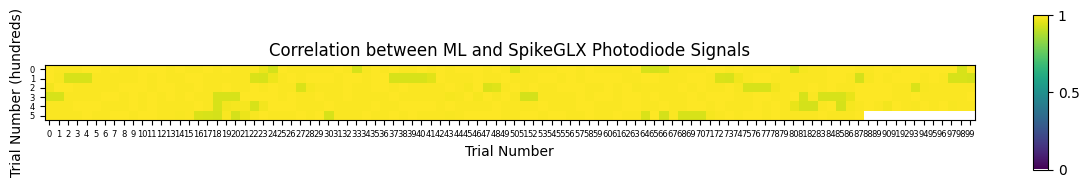

  Done.
Comparing ML and SpikeGLX photodiode signals...
Number of frames in ML Cam TTL: 877633
Number of frames in SpikeGLX Cam TTL: 877704
  Done.
Plotting ML and SpikeGLX photodiode signals...


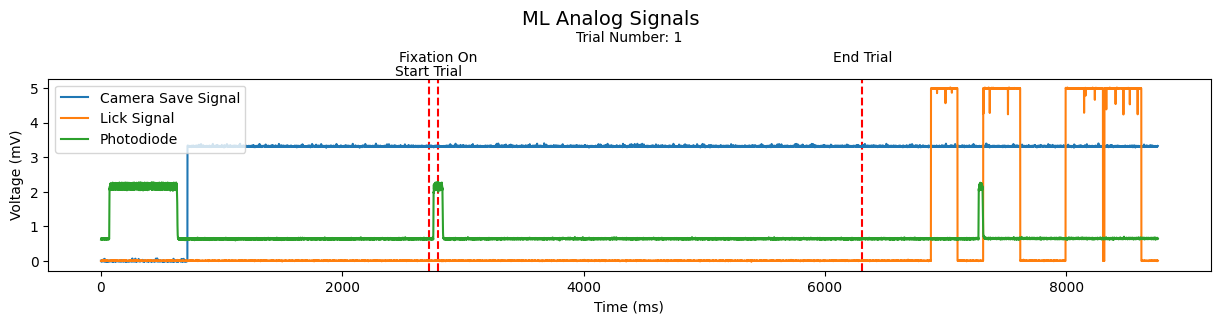

  Done.
Plotting first trial...


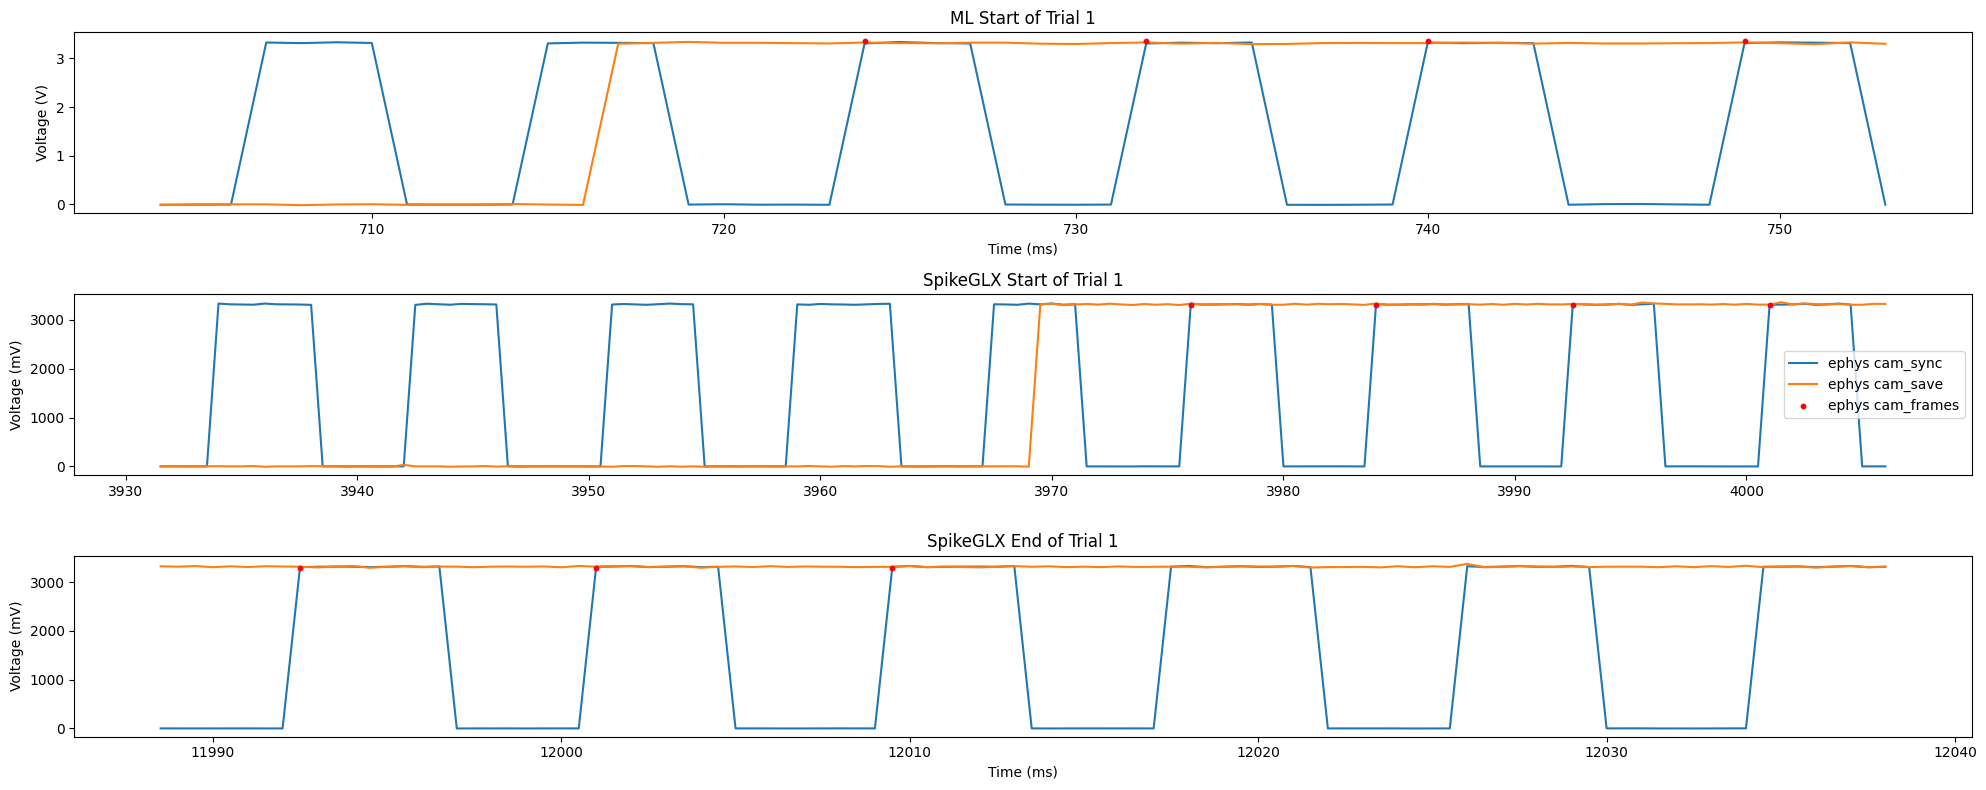

  Done.
Saving spikeglx_obj...
  Pickle file size: 594.017693 MB
  Pickle file path: _data/aragorn_231106/spikeglx_obj_aragorn_231106.pkl
Done. Saved spikeglx_obj.


In [7]:
from spike_glx.load_SGLX import load_sglx

# Load the spikeglx object
spikeglx_obj = load_sglx(session_obj.df, 
                         session_obj, 
                         file_container_obj, 
                         signal_dict, 
                         epochs)

### ML-SpikeGLX Session Correlation
To see just the correlation matrix for each trial in a session, run `plot_spikeglx_ml_corr` with the newly-generated `spikeglx_obj`.

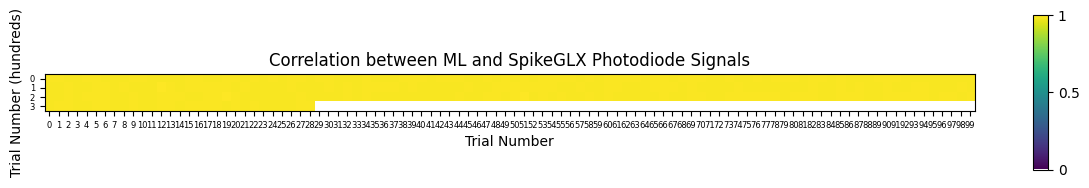

In [8]:
from spike_glx.read_SGLX import plot_spikeglx_ml_corr
plot_spikeglx_ml_corr(spikeglx_obj.ml_sglx_corr_matrix, 100)

***
## Process White Matter Videos

After generating a `SpikeGLX` object, you can segment all the White Matter videos by trial.

In [9]:
from video.wm_videos import parse_wm_videos

if session_obj.monkey == 'gandalf':
  epoch_start = 'start'
  epoch_end = 'end'
else:
  epoch_start = 'Trace Start'
  epoch_end = 'Outcome Start'

kwargs = {'spikeglx_obj': spikeglx_obj,       # 'spikeglx_obj': spikeglx_obj
          'session_obj': session_obj,         # 'session_obj': session_obj
          'trial_start': 0,                   # 'trial_start': 0 
          'trial_end': len(session_obj.df),   # 'trial_end': len(session_obj.df)
          'epoch_start': epoch_start,         # 'epoch_start': 'start'
          'epoch_end': epoch_end,             # 'epoch_end': 'end'   
          'thread_flag': False}               # 'thread_flag': False

parse_wm_videos(**kwargs)

TypeError: 'float' object cannot be interpreted as an integer

***
## DeepLabCut

In [9]:
import deeplabcut

camera_dict = {
  'e3v8360':'face_1', 
  'e3v83d6':'face_2',
  'e3v83ad':'body_1',
  'e3v831b':'body_2'
}

Loading DLC 2.3.5...


In [10]:
from dlc_primate.dlc_utils import dlc_config, dlc_downsample
video_dir = os.path.join(os.getcwd(), 'video', session_obj.monkey + '_' + session_obj.date)
dlc_video_path_dict = dlc_config.get_trial_video_list(video_dir, camera_dict)
# dlc_video_path_dict = spikeglx_obj.video_file_paths

Checking for video files...
  Video directory: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023


  0%|          | 0/1310 [00:00<?, ?it/s]

  Camera: e3v83d6 | Number of videos: 325
  Camera: e3v8360 | Number of videos: 335
  Camera: e3v831b | Number of videos: 325
  Camera: e3v83ad | Number of videos: 325


In [ ]:
# Custom modules
from dlc_primate.dlc_utils import dlc_config, dlc_downsample

# Initialize Project
config_path_dict, train_config_path_dict = \
  dlc_config.dlc_initialize_project(dlc_video_path_dict, session_obj, camera_dict)

In [ ]:
# Run DLC
dlc_config.dlc_run(config_path_dict, dlc_video_path_dict, 
                   start_video=0, end_video=None, videotype='mp4')

***
## Generate MonkeyLogic Behavior Trial Videos

In [56]:
from video.ml_videos import generate_ml_behavior_videos
trial_num_selected = 1
generate_ml_behavior_videos(session_obj.df, session_obj, trial_num_selected, epoch_start, epoch_end)

Generating video for trial 1
Generating frames for trial 1 from 0 to 12264


Trial 1 frame:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4


Trial 0 eye:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4


Trial 0 lick:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting image folder: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/trial_0


TypeError: 'recursive' is an invalid keyword argument for rmdir()